In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import time
from pickle import load
import tensorflow as tf
from tensorflow import keras
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

tf.random.set_seed(42)
K = keras.backend

from sklearn.preprocessing import StandardScaler,PowerTransformer
import math
from scipy.stats import multivariate_normal
from scipy.stats import norm
import os
from helper import *

hr_data = np.load("ks_coarse_grained.npy")

data = np.mean(hr_data.reshape((hr_data.shape[0],20,5),order="C"),axis=-1)

# Can change amount of training data here. When we use only first 2000 or so, we get a bigger improvement 
# from transfer learning approach, even if dropout is included. 

training_data = data[:10000,:]
hold_out_val = data[20000:30000]
hold_out = data[70000:,:]

training_data_high_res = hr_data[:10000,:]
hold_out_val_high_res = hr_data[20000:30000]
hold_out_high_res = hr_data[70000:,:]

training_data_scaled = (training_data - training_data.mean())/training_data.std()
hold_out_val_scaled = (hold_out_val-training_data.mean())/training_data.std()
hold_out_scaled = (hold_out-training_data.mean())/training_data.std()

training_data_scaled = np.expand_dims(training_data_scaled,axis=1)
hold_out_val_scaled = np.expand_dims(hold_out_val_scaled,axis=1)
hold_out_scaled = np.expand_dims(hold_out_scaled,axis=1)


training_data_hr_scaled = (training_data_high_res - training_data_high_res.mean())/training_data_high_res.std()
hold_out_hr_val_scaled = (hold_out_val_high_res-training_data_high_res.mean())/training_data_high_res.std()
hold_out_hr_scaled = (hold_out_high_res-training_data_high_res.mean())/training_data_high_res.std()


training_data_hr_scaled = np.expand_dims(training_data_hr_scaled,axis=1)
hold_out_hr_val_scaled = np.expand_dims(hold_out_hr_val_scaled,axis=1)
hold_out_hr_scaled = np.expand_dims(hold_out_hr_scaled,axis=1)


history_length = 100

k = 1

num_dims = 20
num_dims_hr = 100

#Prepare RNN sequences

def prepare_datasets_for_RNN(dataset,history_length,num_dims):
    dataset = dataset[:(dataset.shape[0]//history_length)*history_length,:] # to make it multiple of history
    dataset_shape = dataset.shape[0]
    reshaped = dataset.reshape(int(dataset_shape/history_length),history_length,k,num_dims)
    add_on = reshaped[1:,0,:,:]
    add_on = add_on.reshape(int(dataset_shape/history_length)-1,1,k,num_dims)
    reshaped = reshaped[:-1,:,:,:]
    concat = np.concatenate((reshaped,add_on),axis=1)
    concat = concat.reshape(((int(dataset_shape/history_length)-1)*(history_length+1),k,num_dims))
    concat = concat.reshape((k*(int(dataset_shape/history_length)-1)*(history_length+1),num_dims),order="F")
    features = concat.reshape(k*(int(dataset_shape/history_length)-1),(history_length+1),num_dims)
    
    return features

train_nn_features = prepare_datasets_for_RNN(training_data_scaled,history_length,num_dims)
valid_nn_features = prepare_datasets_for_RNN(hold_out_val_scaled,history_length,num_dims)
test_nn_features = hold_out_scaled.transpose([1,0,2])

train_hr_nn_features = prepare_datasets_for_RNN(training_data_hr_scaled,history_length,num_dims_hr)
valid_hr_nn_features =  prepare_datasets_for_RNN(hold_out_hr_val_scaled,history_length,num_dims_hr)
test_hr_nn_features =  hold_out_hr_scaled.transpose([1,0,2])

# RNN #

In [2]:
train_nn_input = train_nn_features[:,:-1,:]
train_nn_output = train_nn_features[:,1:,:]

train_hr_nn_input = train_hr_nn_features[:,:-1,:]
train_hr_nn_output = train_hr_nn_features[:,1:,:]

train_shape = train_nn_input.shape[0]


valid_nn_input = valid_nn_features[:,:-1,:]
valid_nn_output = valid_nn_features[:,1:,:]

valid_hr_nn_input = valid_hr_nn_features[:,:-1,:]
valid_hr_nn_output = valid_hr_nn_features[:,1:,:]

valid_shape = valid_nn_input.shape[0]


test_nn_input = test_nn_features[:,:-1,:]
test_nn_output = test_nn_features[:,1:,:]

test_hr_nn_input = test_hr_nn_features[:,:-1,:]
test_hr_nn_output = test_hr_nn_features[:,1:,:]

test_shape = test_nn_input.shape[0]

def loglik_gaussian_x(array,mean,sigma):
    term = -K.log(sigma**2 * 2*math.pi) - tf.math.divide((array-mean),sigma)**2
    loglik = 0.5*term
    return tf.math.reduce_sum(loglik,axis=[1,2])

def loglik_gaussian_hr(array,mean,sigma):
    term = -K.log(sigma**2 * 2*math.pi) - tf.math.divide((array-mean),sigma)**2
    loglik = 0.5*term
    return tf.math.reduce_sum(loglik,axis=[1,2])

def loss(loglikelihood_x):
    loglik = loglikelihood_x 
    loss = -loglik / history_length #to make it avg per spatial vector
    return tf.reduce_mean(loss)

def valid_loss(valid_list,simulator,sigma_x,hr=False):
    mean = simulator(valid_list,training=False)[0]
    if hr == False:
        return -np.mean(loglik_gaussian_x(valid_list[1],mean,sigma_x))
    if hr == True:
        return -np.mean(loglik_gaussian_x(valid_list[3],mean,sigma_x))


hidden_state_size = 8

hidden_in_train = np.zeros(shape=(train_shape,hidden_state_size))
input_list = [train_nn_input,train_nn_output,train_hr_nn_input,train_hr_nn_output,hidden_in_train]

hidden_in_test = np.zeros(shape=(test_shape,hidden_state_size))
test_list = [test_nn_input,test_nn_output,test_hr_nn_input,test_hr_nn_output,hidden_in_test]

hidden_in_valid = np.zeros(shape=(valid_shape,hidden_state_size))
valid_list = [valid_nn_input,valid_nn_output,valid_hr_nn_input,valid_hr_nn_output,hidden_in_valid]

# No TL #

0


2022-09-11 14:07:31.708685: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-11 14:07:32.452008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7408 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:3b:00.0, compute capability: 6.1


Epoch 0/200


2022-09-11 14:07:33.652964: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-11 14:07:34.272186: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


99/99 [==============================] - trainLoss: 18.4026  Val_loss: 660.7765 
Epoch 1/200
99/99 [==============================] - trainLoss: 16.8881  Val_loss: 564.9594 
Epoch 2/200
99/99 [==============================] - trainLoss: 14.6874  Val_loss: 484.7906 
Epoch 3/200
99/99 [==============================] - trainLoss: 12.8669  Val_loss: 423.4495 
Epoch 4/200
99/99 [==============================] - trainLoss: 12.6050  Val_loss: 384.1761 
Epoch 5/200
99/99 [==============================] - trainLoss: 10.3901  Val_loss: 362.8312 
Epoch 6/200
99/99 [==============================] - trainLoss: 8.8495  Val_loss: 366.5126 
Epoch 7/200
99/99 [==============================] - trainLoss: 7.7661  Val_loss: 395.8059 
Epoch 8/200
99/99 [==============================] - trainLoss: 6.4287  Val_loss: 441.3385 
Epoch 9/200
99/99 [==============================] - trainLoss: 5.2762  Val_loss: 504.5482 
Epoch 10/200
99/99 [==============================] - trainLoss: 4.4444  Val_loss: 570

99/99 [==============================] - trainLoss: -93.7310  Val_loss: -1675.3729 
Epoch 68/200
99/99 [==============================] - trainLoss: -94.3850  Val_loss: 736.7327 
Epoch 69/200
99/99 [==============================] - trainLoss: -94.8494  Val_loss: 544.6407 
Epoch 70/200
99/99 [==============================] - trainLoss: -94.9650  Val_loss: 2090.3069 
Epoch 71/200
99/99 [==============================] - trainLoss: -95.2223  Val_loss: 1558.7887 
Epoch 72/200
99/99 [==============================] - trainLoss: -95.8926  Val_loss: 3334.6284 
Epoch 73/200
99/99 [==============================] - trainLoss: -95.7834  Val_loss: 5026.2114 
Epoch 74/200
99/99 [==============================] - trainLoss: -95.5942  Val_loss: 5186.8511 
Epoch 75/200
99/99 [==============================] - trainLoss: -96.9847  Val_loss: 6000.3989 
Epoch 76/200
99/99 [==============================] - trainLoss: -94.9903  Val_loss: 7223.5791 
Epoch 77/200
99/99 [==============================] - 

99/99 [==============================] - trainLoss: -102.1395  Val_loss: 13151.3691 
Epoch 150/200
99/99 [==============================] - trainLoss: -103.1329  Val_loss: 12388.5791 
Epoch 151/200
99/99 [==============================] - trainLoss: -102.2904  Val_loss: 9472.7744 
Epoch 152/200
99/99 [==============================] - trainLoss: -102.3812  Val_loss: 8860.9619 
Epoch 153/200
99/99 [==============================] - trainLoss: -101.5456  Val_loss: 8241.5117 
Epoch 154/200
99/99 [==============================] - trainLoss: -102.6214  Val_loss: 8786.1445 
Epoch 155/200
99/99 [==============================] - trainLoss: -101.5878  Val_loss: 10206.3721 
Epoch 156/200
99/99 [==============================] - trainLoss: -102.9808  Val_loss: 10354.8623 
Epoch 157/200
99/99 [==============================] - trainLoss: -102.8734  Val_loss: 9657.4111 
Epoch 158/200
99/99 [==============================] - trainLoss: -102.6800  Val_loss: 10436.5938 
Epoch 159/200
99/99 [========

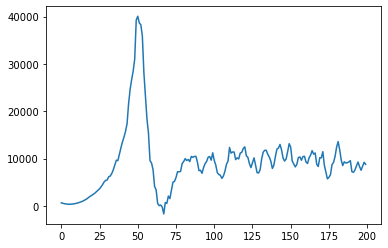

1
Epoch 0/200
99/99 [==============================] - trainLoss: 13.6514  Val_loss: 579.9417 
Epoch 1/200
99/99 [==============================] - trainLoss: 11.9067  Val_loss: 499.3145 
Epoch 2/200
99/99 [==============================] - trainLoss: 10.4402  Val_loss: 436.0240 
Epoch 3/200
99/99 [==============================] - trainLoss: 9.1544  Val_loss: 390.9359 
Epoch 4/200
99/99 [==============================] - trainLoss: 7.0204  Val_loss: 372.8230 
Epoch 5/200
99/99 [==============================] - trainLoss: 5.3920  Val_loss: 389.0883 
Epoch 6/200
99/99 [==============================] - trainLoss: 3.0529  Val_loss: 432.8750 
Epoch 7/200
99/99 [==============================] - trainLoss: 2.2040  Val_loss: 487.2746 
Epoch 8/200
99/99 [==============================] - trainLoss: 0.2626  Val_loss: 570.9281 
Epoch 9/200
99/99 [==============================] - trainLoss: -1.9730  Val_loss: 655.3566 
Epoch 10/200
99/99 [==============================] - trainLoss: -2.3959  

99/99 [==============================] - trainLoss: -91.8424  Val_loss: -1878.5146 
Epoch 65/200
99/99 [==============================] - trainLoss: -93.0057  Val_loss: -1828.3014 
Epoch 66/200
99/99 [==============================] - trainLoss: -92.2056  Val_loss: -1628.5820 
Epoch 67/200
99/99 [==============================] - trainLoss: -94.3109  Val_loss: -2210.9958 
Epoch 68/200
99/99 [==============================] - trainLoss: -94.3201  Val_loss: -1713.6492 
Epoch 69/200
99/99 [==============================] - trainLoss: -94.6912  Val_loss: -1537.7628 
Epoch 70/200
99/99 [==============================] - trainLoss: -95.2164  Val_loss: -1106.4849 
Epoch 71/200
99/99 [==============================] - trainLoss: -95.1188  Val_loss: -1424.7579 
Epoch 72/200
99/99 [==============================] - trainLoss: -96.2251  Val_loss: -1391.7441 
Epoch 73/200
99/99 [==============================] - trainLoss: -95.5139  Val_loss: 540.1505 
Epoch 74/200
99/99 [=========================

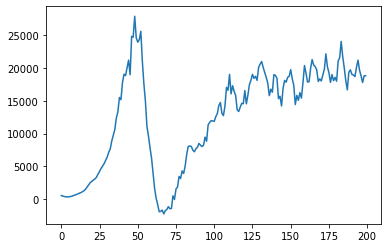

2
Epoch 0/200
99/99 [==============================] - trainLoss: 16.7112  Val_loss: 818.5536 
Epoch 1/200
99/99 [==============================] - trainLoss: 15.2590  Val_loss: 742.3434 
Epoch 2/200
99/99 [==============================] - trainLoss: 14.3601  Val_loss: 672.1094 
Epoch 3/200
99/99 [==============================] - trainLoss: 12.2015  Val_loss: 613.8893 
Epoch 4/200
99/99 [==============================] - trainLoss: 11.4236  Val_loss: 575.7488 
Epoch 5/200
99/99 [==============================] - trainLoss: 10.1153  Val_loss: 557.3664 
Epoch 6/200
99/99 [==============================] - trainLoss: 8.7057  Val_loss: 566.0759 
Epoch 7/200
99/99 [==============================] - trainLoss: 7.1613  Val_loss: 605.4063 
Epoch 8/200
99/99 [==============================] - trainLoss: 6.1486  Val_loss: 680.6624 
Epoch 9/200
99/99 [==============================] - trainLoss: 4.5005  Val_loss: 800.1958 
Epoch 10/200
99/99 [==============================] - trainLoss: 3.4324 

99/99 [==============================] - trainLoss: -94.3909  Val_loss: 188.8715 
Epoch 68/200
99/99 [==============================] - trainLoss: -92.6093  Val_loss: -782.4329 
Epoch 69/200
99/99 [==============================] - trainLoss: -95.8256  Val_loss: -940.4280 
Epoch 70/200
99/99 [==============================] - trainLoss: -95.6593  Val_loss: -1716.3282 
Epoch 71/200
99/99 [==============================] - trainLoss: -95.0652  Val_loss: -815.1218 
Epoch 72/200
99/99 [==============================] - trainLoss: -95.1253  Val_loss: -1155.7285 
Epoch 73/200
99/99 [==============================] - trainLoss: -96.7782  Val_loss: -471.8120 
Epoch 74/200
99/99 [==============================] - trainLoss: -96.9529  Val_loss: -593.0084 
Epoch 75/200
99/99 [==============================] - trainLoss: -96.6572  Val_loss: 840.1070 
Epoch 76/200
99/99 [==============================] - trainLoss: -96.1435  Val_loss: 1267.7092 
Epoch 77/200
99/99 [==============================] -

99/99 [==============================] - trainLoss: -100.6081  Val_loss: 16185.6309 
Epoch 146/200
99/99 [==============================] - trainLoss: -101.2268  Val_loss: 19400.1270 
Epoch 147/200
99/99 [==============================] - trainLoss: -102.0473  Val_loss: 20935.6816 
Epoch 148/200
99/99 [==============================] - trainLoss: -101.7756  Val_loss: 22697.6309 
Epoch 149/200
99/99 [==============================] - trainLoss: -102.0678  Val_loss: 20156.7383 
Epoch 150/200
99/99 [==============================] - trainLoss: -102.2178  Val_loss: 20196.6523 
Epoch 151/200
99/99 [==============================] - trainLoss: -102.6900  Val_loss: 20526.7227 
Epoch 152/200
99/99 [==============================] - trainLoss: -101.4085  Val_loss: 21860.6387 
Epoch 153/200
99/99 [==============================] - trainLoss: -102.2119  Val_loss: 20757.8555 
Epoch 154/200
99/99 [==============================] - trainLoss: -101.9425  Val_loss: 20907.5566 
Epoch 155/200
99/99 [===

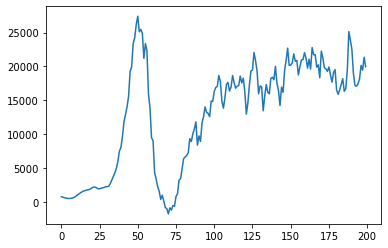

3
Epoch 0/200
99/99 [==============================] - trainLoss: 21.0671  Val_loss: 884.1255 
Epoch 1/200
99/99 [==============================] - trainLoss: 20.3430  Val_loss: 761.5704 
Epoch 2/200
99/99 [==============================] - trainLoss: 18.8374  Val_loss: 640.7850 
Epoch 3/200
99/99 [==============================] - trainLoss: 17.8716  Val_loss: 526.8738 
Epoch 4/200
99/99 [==============================] - trainLoss: 16.0920  Val_loss: 422.0121 
Epoch 5/200
99/99 [==============================] - trainLoss: 14.6065  Val_loss: 326.5237 
Epoch 6/200
99/99 [==============================] - trainLoss: 12.6708  Val_loss: 242.0982 
Epoch 7/200
99/99 [==============================] - trainLoss: 11.8600  Val_loss: 170.3473 
Epoch 8/200
99/99 [==============================] - trainLoss: 10.9508  Val_loss: 112.2105 
Epoch 9/200
99/99 [==============================] - trainLoss: 10.2545  Val_loss: 71.8261 
Epoch 10/200
99/99 [==============================] - trainLoss: 8.88

99/99 [==============================] - trainLoss: -100.2207  Val_loss: 19961.7227 
Epoch 134/200
99/99 [==============================] - trainLoss: -100.2724  Val_loss: 18162.2559 
Epoch 135/200
99/99 [==============================] - trainLoss: -101.5951  Val_loss: 16854.4453 
Epoch 136/200
99/99 [==============================] - trainLoss: -102.4727  Val_loss: 14426.4512 
Epoch 137/200
99/99 [==============================] - trainLoss: -101.6020  Val_loss: 14151.7363 
Epoch 138/200
99/99 [==============================] - trainLoss: -102.7065  Val_loss: 15288.6406 
Epoch 139/200
99/99 [==============================] - trainLoss: -101.3329  Val_loss: 17429.9727 
Epoch 140/200
99/99 [==============================] - trainLoss: -102.5588  Val_loss: 17961.4922 
Epoch 141/200
99/99 [==============================] - trainLoss: -101.8380  Val_loss: 18006.1953 
Epoch 142/200
99/99 [==============================] - trainLoss: -103.0417  Val_loss: 17794.7520 
Epoch 143/200
99/99 [===

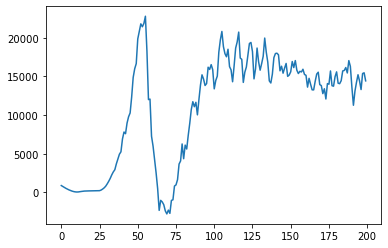

4
Epoch 0/200
99/99 [==============================] - trainLoss: 12.7736  Val_loss: 1080.7117 
Epoch 1/200
99/99 [==============================] - trainLoss: 10.9129  Val_loss: 1123.0209 
Epoch 2/200
99/99 [==============================] - trainLoss: 9.7775  Val_loss: 1175.6160 
Epoch 3/200
99/99 [==============================] - trainLoss: 8.8820  Val_loss: 1249.1179 
Epoch 4/200
99/99 [==============================] - trainLoss: 7.7881  Val_loss: 1342.2140 
Epoch 5/200
99/99 [==============================] - trainLoss: 6.9568  Val_loss: 1457.9438 
Epoch 6/200
99/99 [==============================] - trainLoss: 6.2235  Val_loss: 1586.5815 
Epoch 7/200
99/99 [==============================] - trainLoss: 4.5887  Val_loss: 1718.6088 
Epoch 8/200
99/99 [==============================] - trainLoss: 3.0302  Val_loss: 1852.7711 
Epoch 9/200
99/99 [==============================] - trainLoss: 1.7515  Val_loss: 1980.8956 
Epoch 10/200
99/99 [==============================] - trainLoss: 1

99/99 [==============================] - trainLoss: -94.8426  Val_loss: -3536.2341 
Epoch 69/200
99/99 [==============================] - trainLoss: -94.9912  Val_loss: -3979.0486 
Epoch 70/200
99/99 [==============================] - trainLoss: -95.1303  Val_loss: -3948.6387 
Epoch 71/200
99/99 [==============================] - trainLoss: -95.0868  Val_loss: -3861.1941 
Epoch 72/200
99/99 [==============================] - trainLoss: -97.0825  Val_loss: -3867.6260 
Epoch 73/200
99/99 [==============================] - trainLoss: -95.6908  Val_loss: -4251.8799 
Epoch 74/200
99/99 [==============================] - trainLoss: -96.3431  Val_loss: -3859.9792 
Epoch 75/200
99/99 [==============================] - trainLoss: -96.3214  Val_loss: -3322.5798 
Epoch 76/200
99/99 [==============================] - trainLoss: -98.0909  Val_loss: -3505.2539 
Epoch 77/200
99/99 [==============================] - trainLoss: -97.1524  Val_loss: -2981.7439 
Epoch 78/200
99/99 [=======================

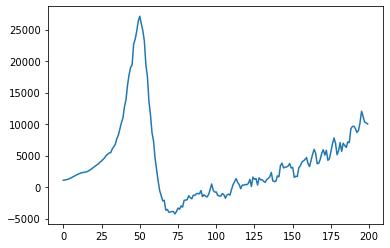

5
Epoch 0/200
99/99 [==============================] - trainLoss: 21.8412  Val_loss: 1263.0085 
Epoch 1/200
99/99 [==============================] - trainLoss: 18.8858  Val_loss: 1207.8788 
Epoch 2/200
99/99 [==============================] - trainLoss: 17.0393  Val_loss: 1193.1483 
Epoch 3/200
99/99 [==============================] - trainLoss: 14.7292  Val_loss: 1208.3717 
Epoch 4/200
99/99 [==============================] - trainLoss: 13.4756  Val_loss: 1248.6844 
Epoch 5/200
99/99 [==============================] - trainLoss: 11.7308  Val_loss: 1290.5153 
Epoch 6/200
99/99 [==============================] - trainLoss: 10.6908  Val_loss: 1308.2755 
Epoch 7/200
99/99 [==============================] - trainLoss: 8.7989  Val_loss: 1294.2377 
Epoch 8/200
99/99 [==============================] - trainLoss: 7.8858  Val_loss: 1252.6017 
Epoch 9/200
99/99 [==============================] - trainLoss: 6.2307  Val_loss: 1196.7083 
Epoch 10/200
99/99 [==============================] - trainLo

99/99 [==============================] - trainLoss: -101.9132  Val_loss: 30870.1289 
Epoch 155/200
99/99 [==============================] - trainLoss: -101.9404  Val_loss: 29657.6309 
Epoch 156/200
99/99 [==============================] - trainLoss: -102.1841  Val_loss: 30080.4688 
Epoch 157/200
99/99 [==============================] - trainLoss: -102.4285  Val_loss: 31161.7695 
Epoch 158/200
99/99 [==============================] - trainLoss: -101.2588  Val_loss: 33090.0000 
Epoch 159/200
99/99 [==============================] - trainLoss: -101.8524  Val_loss: 33854.9805 
Epoch 160/200
99/99 [==============================] - trainLoss: -101.2560  Val_loss: 32718.4805 
Epoch 161/200
99/99 [==============================] - trainLoss: -101.3299  Val_loss: 34361.5195 
Epoch 162/200
99/99 [==============================] - trainLoss: -102.0743  Val_loss: 31477.6543 
Epoch 163/200
99/99 [==============================] - trainLoss: -101.3376  Val_loss: 30458.0840 
Epoch 164/200
99/99 [===

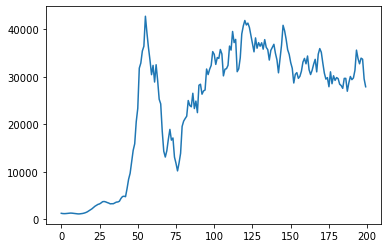

6
Epoch 0/200
99/99 [==============================] - trainLoss: 16.1445  Val_loss: 1114.9137 
Epoch 1/200
99/99 [==============================] - trainLoss: 13.9645  Val_loss: 1040.5026 
Epoch 2/200
99/99 [==============================] - trainLoss: 12.8914  Val_loss: 966.1487 
Epoch 3/200
99/99 [==============================] - trainLoss: 11.4935  Val_loss: 893.5076 
Epoch 4/200
99/99 [==============================] - trainLoss: 9.8868  Val_loss: 824.0969 
Epoch 5/200
99/99 [==============================] - trainLoss: 8.4862  Val_loss: 750.3642 
Epoch 6/200
99/99 [==============================] - trainLoss: 7.1651  Val_loss: 668.0682 
Epoch 7/200
99/99 [==============================] - trainLoss: 5.6262  Val_loss: 577.0523 
Epoch 8/200
99/99 [==============================] - trainLoss: 4.2443  Val_loss: 476.8074 
Epoch 9/200
99/99 [==============================] - trainLoss: 3.1886  Val_loss: 362.3847 
Epoch 10/200
99/99 [==============================] - trainLoss: 1.9177 

99/99 [==============================] - trainLoss: -100.4570  Val_loss: 16295.7334 
Epoch 115/200
99/99 [==============================] - trainLoss: -100.7687  Val_loss: 13451.6729 
Epoch 116/200
99/99 [==============================] - trainLoss: -100.2503  Val_loss: 15422.0615 
Epoch 117/200
99/99 [==============================] - trainLoss: -100.9202  Val_loss: 14544.3438 
Epoch 118/200
99/99 [==============================] - trainLoss: -98.7246  Val_loss: 17596.6562 
Epoch 119/200
99/99 [==============================] - trainLoss: -100.2184  Val_loss: 20636.3984 
Epoch 120/200
99/99 [==============================] - trainLoss: -100.3080  Val_loss: 21671.7695 
Epoch 121/200
99/99 [==============================] - trainLoss: -98.9984  Val_loss: 19395.5137 
Epoch 122/200
99/99 [==============================] - trainLoss: -101.2428  Val_loss: 14707.6084 
Epoch 123/200
99/99 [==============================] - trainLoss: -100.1129  Val_loss: 14472.8916 
Epoch 124/200
99/99 [=====

99/99 [==============================] - trainLoss: -102.5065  Val_loss: 28014.9453 
Epoch 199/200
99/99 [==============================] - trainLoss: -104.0942  Val_loss: 26561.1953 


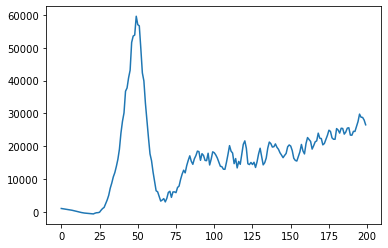

7
Epoch 0/200
99/99 [==============================] - trainLoss: 13.2387  Val_loss: 1279.2102 
Epoch 1/200
99/99 [==============================] - trainLoss: 12.1365  Val_loss: 1306.4553 
Epoch 2/200
99/99 [==============================] - trainLoss: 11.1427  Val_loss: 1359.5743 
Epoch 3/200
99/99 [==============================] - trainLoss: 9.4732  Val_loss: 1418.3765 
Epoch 4/200
99/99 [==============================] - trainLoss: 8.4138  Val_loss: 1491.1045 
Epoch 5/200
99/99 [==============================] - trainLoss: 7.2098  Val_loss: 1581.0188 
Epoch 6/200
99/99 [==============================] - trainLoss: 5.8415  Val_loss: 1725.1704 
Epoch 7/200
99/99 [==============================] - trainLoss: 5.0445  Val_loss: 1930.2405 
Epoch 8/200
99/99 [==============================] - trainLoss: 4.6480  Val_loss: 2198.9016 
Epoch 9/200
99/99 [==============================] - trainLoss: 2.5039  Val_loss: 2482.6658 
Epoch 10/200
99/99 [==============================] - trainLoss: 

99/99 [==============================] - trainLoss: -92.5727  Val_loss: -5630.4146 
Epoch 65/200
99/99 [==============================] - trainLoss: -92.6819  Val_loss: -5612.6187 
Epoch 66/200
99/99 [==============================] - trainLoss: -93.2952  Val_loss: -5816.5449 
Epoch 67/200
99/99 [==============================] - trainLoss: -92.9643  Val_loss: -5770.7480 
Epoch 68/200
99/99 [==============================] - trainLoss: -93.0404  Val_loss: -5637.3145 
Epoch 69/200
99/99 [==============================] - trainLoss: -95.2363  Val_loss: -4480.9712 
Epoch 70/200
99/99 [==============================] - trainLoss: -96.3847  Val_loss: -4423.8345 
Epoch 71/200
99/99 [==============================] - trainLoss: -95.9023  Val_loss: -4169.8892 
Epoch 72/200
99/99 [==============================] - trainLoss: -94.0918  Val_loss: -3231.5527 
Epoch 73/200
99/99 [==============================] - trainLoss: -95.8854  Val_loss: -927.3602 
Epoch 74/200
99/99 [========================

99/99 [==============================] - trainLoss: -101.3221  Val_loss: 9902.2617 
Epoch 147/200
99/99 [==============================] - trainLoss: -100.8643  Val_loss: 10596.3633 
Epoch 148/200
99/99 [==============================] - trainLoss: -101.4230  Val_loss: 12126.7861 
Epoch 149/200
99/99 [==============================] - trainLoss: -101.5756  Val_loss: 11110.7852 
Epoch 150/200
99/99 [==============================] - trainLoss: -101.4708  Val_loss: 9274.8164 
Epoch 151/200
99/99 [==============================] - trainLoss: -101.7241  Val_loss: 10379.0488 
Epoch 152/200
99/99 [==============================] - trainLoss: -102.4287  Val_loss: 9986.6289 
Epoch 153/200
99/99 [==============================] - trainLoss: -101.2441  Val_loss: 10434.9229 
Epoch 154/200
99/99 [==============================] - trainLoss: -102.2862  Val_loss: 11214.9922 
Epoch 155/200
99/99 [==============================] - trainLoss: -100.9291  Val_loss: 8358.3428 
Epoch 156/200
99/99 [=======

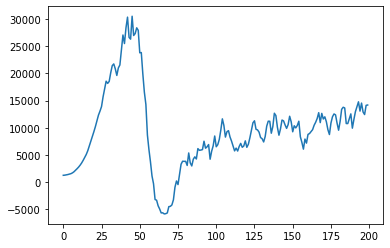

8
Epoch 0/200
99/99 [==============================] - trainLoss: 15.5388  Val_loss: 996.0533 
Epoch 1/200
99/99 [==============================] - trainLoss: 14.1918  Val_loss: 928.2961 
Epoch 2/200
99/99 [==============================] - trainLoss: 13.2592  Val_loss: 871.4932 
Epoch 3/200
99/99 [==============================] - trainLoss: 11.8405  Val_loss: 825.7783 
Epoch 4/200
99/99 [==============================] - trainLoss: 9.4545  Val_loss: 789.0574 
Epoch 5/200
99/99 [==============================] - trainLoss: 9.2281  Val_loss: 768.1470 
Epoch 6/200
99/99 [==============================] - trainLoss: 8.0879  Val_loss: 771.8707 
Epoch 7/200
99/99 [==============================] - trainLoss: 7.3081  Val_loss: 809.6420 
Epoch 8/200
99/99 [==============================] - trainLoss: 6.1842  Val_loss: 890.5615 
Epoch 9/200
99/99 [==============================] - trainLoss: 4.6224  Val_loss: 1034.7418 
Epoch 10/200
99/99 [==============================] - trainLoss: 3.5090  

99/99 [==============================] - trainLoss: -93.7031  Val_loss: 3853.0171 
Epoch 69/200
99/99 [==============================] - trainLoss: -94.5401  Val_loss: 3900.1067 
Epoch 70/200
99/99 [==============================] - trainLoss: -95.4609  Val_loss: 4086.7324 
Epoch 71/200
99/99 [==============================] - trainLoss: -95.4815  Val_loss: 3508.7078 
Epoch 72/200
99/99 [==============================] - trainLoss: -94.8527  Val_loss: 4203.5303 
Epoch 73/200
99/99 [==============================] - trainLoss: -96.3109  Val_loss: 3065.8018 
Epoch 74/200
99/99 [==============================] - trainLoss: -96.9752  Val_loss: 3632.7466 
Epoch 75/200
99/99 [==============================] - trainLoss: -95.1642  Val_loss: 4721.6104 
Epoch 76/200
99/99 [==============================] - trainLoss: -95.9050  Val_loss: 3894.4697 
Epoch 77/200
99/99 [==============================] - trainLoss: -96.3616  Val_loss: 5945.8726 
Epoch 78/200
99/99 [==============================] -

99/99 [==============================] - trainLoss: -101.3980  Val_loss: 12580.9902 
Epoch 155/200
99/99 [==============================] - trainLoss: -100.5583  Val_loss: 12126.5908 
Epoch 156/200
99/99 [==============================] - trainLoss: -101.4859  Val_loss: 13001.9863 
Epoch 157/200
99/99 [==============================] - trainLoss: -100.4643  Val_loss: 14062.0820 
Epoch 158/200
99/99 [==============================] - trainLoss: -102.6168  Val_loss: 16550.5332 
Epoch 159/200
99/99 [==============================] - trainLoss: -101.2224  Val_loss: 17046.5625 
Epoch 160/200
99/99 [==============================] - trainLoss: -100.9290  Val_loss: 14457.6592 
Epoch 161/200
99/99 [==============================] - trainLoss: -100.9527  Val_loss: 11848.4600 
Epoch 162/200
99/99 [==============================] - trainLoss: -100.3722  Val_loss: 13434.7148 
Epoch 163/200
99/99 [==============================] - trainLoss: -101.1667  Val_loss: 12678.4609 
Epoch 164/200
99/99 [===

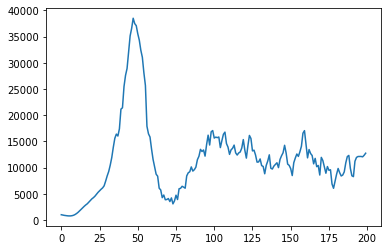

9
Epoch 0/200
99/99 [==============================] - trainLoss: 15.5477  Val_loss: 979.1281 
Epoch 1/200
99/99 [==============================] - trainLoss: 14.5819  Val_loss: 886.6677 
Epoch 2/200
99/99 [==============================] - trainLoss: 12.9914  Val_loss: 812.2580 
Epoch 3/200
99/99 [==============================] - trainLoss: 10.7329  Val_loss: 754.3768 
Epoch 4/200
99/99 [==============================] - trainLoss: 9.4962  Val_loss: 718.1462 
Epoch 5/200
99/99 [==============================] - trainLoss: 7.9964  Val_loss: 705.8596 
Epoch 6/200
99/99 [==============================] - trainLoss: 6.4103  Val_loss: 713.4639 
Epoch 7/200
99/99 [==============================] - trainLoss: 5.1641  Val_loss: 739.0724 
Epoch 8/200
99/99 [==============================] - trainLoss: 3.8389  Val_loss: 781.1129 
Epoch 9/200
99/99 [==============================] - trainLoss: 2.7600  Val_loss: 840.7330 
Epoch 10/200
99/99 [==============================] - trainLoss: 0.9298  V

99/99 [==============================] - trainLoss: -95.3995  Val_loss: -1047.5459 
Epoch 64/200
99/99 [==============================] - trainLoss: -94.2533  Val_loss: -732.0831 
Epoch 65/200
99/99 [==============================] - trainLoss: -93.5308  Val_loss: -1439.0370 
Epoch 66/200
99/99 [==============================] - trainLoss: -94.0034  Val_loss: -646.9384 
Epoch 67/200
99/99 [==============================] - trainLoss: -94.4874  Val_loss: 197.9653 
Epoch 68/200
99/99 [==============================] - trainLoss: -95.6475  Val_loss: 1215.4673 
Epoch 69/200
99/99 [==============================] - trainLoss: -96.9157  Val_loss: 1744.6620 
Epoch 70/200
99/99 [==============================] - trainLoss: -96.3320  Val_loss: 3843.2314 
Epoch 71/200
99/99 [==============================] - trainLoss: -96.8947  Val_loss: 4902.9712 
Epoch 72/200
99/99 [==============================] - trainLoss: -96.4962  Val_loss: 3796.8560 
Epoch 73/200
99/99 [==============================] 

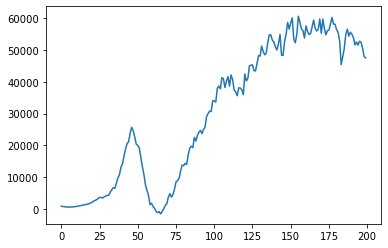

10
Epoch 0/200
99/99 [==============================] - trainLoss: 11.6248  Val_loss: 988.2342 
Epoch 1/200
99/99 [==============================] - trainLoss: 10.5041  Val_loss: 961.6490 
Epoch 2/200
99/99 [==============================] - trainLoss: 9.4048  Val_loss: 936.9701 
Epoch 3/200
99/99 [==============================] - trainLoss: 8.2161  Val_loss: 912.2953 
Epoch 4/200
99/99 [==============================] - trainLoss: 7.7721  Val_loss: 895.2020 
Epoch 5/200
99/99 [==============================] - trainLoss: 7.1244  Val_loss: 886.9310 
Epoch 6/200
99/99 [==============================] - trainLoss: 6.2748  Val_loss: 884.3890 
Epoch 7/200
99/99 [==============================] - trainLoss: 4.8218  Val_loss: 902.0522 
Epoch 8/200
99/99 [==============================] - trainLoss: 4.0448  Val_loss: 951.5645 
Epoch 9/200
99/99 [==============================] - trainLoss: 3.0177  Val_loss: 1022.4464 
Epoch 10/200
99/99 [==============================] - trainLoss: 2.1434  V

99/99 [==============================] - trainLoss: -91.4456  Val_loss: -2827.9727 
Epoch 60/200
99/99 [==============================] - trainLoss: -92.1193  Val_loss: -3339.6272 
Epoch 61/200
99/99 [==============================] - trainLoss: -93.2362  Val_loss: -3533.7146 
Epoch 62/200
99/99 [==============================] - trainLoss: -93.5019  Val_loss: -4107.6660 
Epoch 63/200
99/99 [==============================] - trainLoss: -94.2461  Val_loss: -3888.9297 
Epoch 64/200
99/99 [==============================] - trainLoss: -94.9634  Val_loss: -4137.9209 
Epoch 65/200
99/99 [==============================] - trainLoss: -93.8458  Val_loss: -2902.6777 
Epoch 66/200
99/99 [==============================] - trainLoss: -94.5128  Val_loss: -3152.3105 
Epoch 67/200
99/99 [==============================] - trainLoss: -95.5095  Val_loss: -2880.2141 
Epoch 68/200
99/99 [==============================] - trainLoss: -95.3208  Val_loss: -2786.7805 
Epoch 69/200
99/99 [=======================

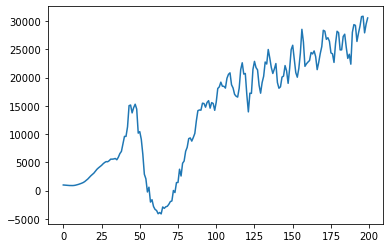

11
Epoch 0/200
99/99 [==============================] - trainLoss: 13.5909  Val_loss: 968.4585 
Epoch 1/200
99/99 [==============================] - trainLoss: 12.7975  Val_loss: 910.0858 
Epoch 2/200
99/99 [==============================] - trainLoss: 11.0612  Val_loss: 852.6724 
Epoch 3/200
99/99 [==============================] - trainLoss: 10.7413  Val_loss: 799.5847 
Epoch 4/200
99/99 [==============================] - trainLoss: 8.5100  Val_loss: 752.3946 
Epoch 5/200
99/99 [==============================] - trainLoss: 7.3981  Val_loss: 712.7988 
Epoch 6/200
99/99 [==============================] - trainLoss: 5.6397  Val_loss: 684.2155 
Epoch 7/200
99/99 [==============================] - trainLoss: 4.9072  Val_loss: 662.1549 
Epoch 8/200
99/99 [==============================] - trainLoss: 3.6523  Val_loss: 651.0499 
Epoch 9/200
99/99 [==============================] - trainLoss: 2.0236  Val_loss: 656.8854 
Epoch 10/200
99/99 [==============================] - trainLoss: 0.9349  

99/99 [==============================] - trainLoss: -102.5976  Val_loss: 13326.2246 
Epoch 138/200
99/99 [==============================] - trainLoss: -101.7099  Val_loss: 11434.0732 
Epoch 139/200
99/99 [==============================] - trainLoss: -101.8189  Val_loss: 11132.1846 
Epoch 140/200
99/99 [==============================] - trainLoss: -101.2986  Val_loss: 11622.5693 
Epoch 141/200
99/99 [==============================] - trainLoss: -101.6286  Val_loss: 10865.9795 
Epoch 142/200
99/99 [==============================] - trainLoss: -101.7909  Val_loss: 12494.1084 
Epoch 143/200
99/99 [==============================] - trainLoss: -102.6779  Val_loss: 13270.5439 
Epoch 144/200
99/99 [==============================] - trainLoss: -102.4162  Val_loss: 11858.1885 
Epoch 145/200
99/99 [==============================] - trainLoss: -102.1584  Val_loss: 7858.6763 
Epoch 146/200
99/99 [==============================] - trainLoss: -102.0735  Val_loss: 11042.1475 
Epoch 147/200
99/99 [====

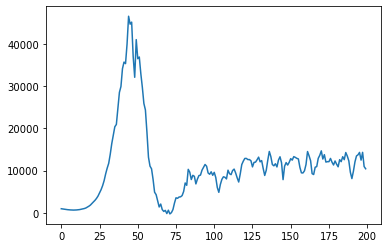

12
Epoch 0/200
99/99 [==============================] - trainLoss: 15.3020  Val_loss: 562.6075 
Epoch 1/200
99/99 [==============================] - trainLoss: 13.6524  Val_loss: 519.3614 
Epoch 2/200
99/99 [==============================] - trainLoss: 11.8162  Val_loss: 525.4003 
Epoch 3/200
99/99 [==============================] - trainLoss: 9.9751  Val_loss: 572.4268 
Epoch 4/200
99/99 [==============================] - trainLoss: 7.7668  Val_loss: 628.3113 
Epoch 5/200
99/99 [==============================] - trainLoss: 7.2166  Val_loss: 647.7601 
Epoch 6/200
99/99 [==============================] - trainLoss: 6.4248  Val_loss: 623.8147 
Epoch 7/200
99/99 [==============================] - trainLoss: 5.5760  Val_loss: 576.1851 
Epoch 8/200
99/99 [==============================] - trainLoss: 4.8185  Val_loss: 533.0575 
Epoch 9/200
99/99 [==============================] - trainLoss: 3.6621  Val_loss: 511.9911 
Epoch 10/200
99/99 [==============================] - trainLoss: 2.5062  V

99/99 [==============================] - trainLoss: -92.9972  Val_loss: -2474.0107 
Epoch 67/200
99/99 [==============================] - trainLoss: -94.0591  Val_loss: -3042.2722 
Epoch 68/200
99/99 [==============================] - trainLoss: -94.4075  Val_loss: -3143.4680 
Epoch 69/200
99/99 [==============================] - trainLoss: -92.8422  Val_loss: -3495.8169 
Epoch 70/200
99/99 [==============================] - trainLoss: -94.9865  Val_loss: -2849.8547 
Epoch 71/200
99/99 [==============================] - trainLoss: -94.8418  Val_loss: -3451.4971 
Epoch 72/200
99/99 [==============================] - trainLoss: -94.5552  Val_loss: -3246.5486 
Epoch 73/200
99/99 [==============================] - trainLoss: -97.0248  Val_loss: -3457.3494 
Epoch 74/200
99/99 [==============================] - trainLoss: -95.6189  Val_loss: -4052.2866 
Epoch 75/200
99/99 [==============================] - trainLoss: -95.8542  Val_loss: -3311.1326 
Epoch 76/200
99/99 [=======================

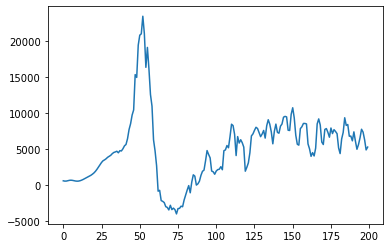

13
Epoch 0/200
99/99 [==============================] - trainLoss: 16.0614  Val_loss: 1333.5598 
Epoch 1/200
99/99 [==============================] - trainLoss: 15.1692  Val_loss: 1325.8940 
Epoch 2/200
99/99 [==============================] - trainLoss: 13.4663  Val_loss: 1328.1853 
Epoch 3/200
99/99 [==============================] - trainLoss: 11.2541  Val_loss: 1332.0653 
Epoch 4/200
99/99 [==============================] - trainLoss: 11.1585  Val_loss: 1331.5060 
Epoch 5/200
99/99 [==============================] - trainLoss: 9.2392  Val_loss: 1309.5959 
Epoch 6/200
99/99 [==============================] - trainLoss: 8.8594  Val_loss: 1287.7104 
Epoch 7/200
99/99 [==============================] - trainLoss: 7.8367  Val_loss: 1288.7458 
Epoch 8/200
99/99 [==============================] - trainLoss: 6.3810  Val_loss: 1302.1425 
Epoch 9/200
99/99 [==============================] - trainLoss: 5.3504  Val_loss: 1335.6913 
Epoch 10/200
99/99 [==============================] - trainLos

99/99 [==============================] - trainLoss: -100.7300  Val_loss: 18044.7012 
Epoch 157/200
99/99 [==============================] - trainLoss: -101.2500  Val_loss: 19010.3242 
Epoch 158/200
99/99 [==============================] - trainLoss: -102.1813  Val_loss: 17810.1055 
Epoch 159/200
99/99 [==============================] - trainLoss: -103.0244  Val_loss: 16723.1133 
Epoch 160/200
99/99 [==============================] - trainLoss: -101.7936  Val_loss: 17814.9785 
Epoch 161/200
99/99 [==============================] - trainLoss: -102.7465  Val_loss: 16150.6279 
Epoch 162/200
99/99 [==============================] - trainLoss: -102.0567  Val_loss: 14790.4658 
Epoch 163/200
99/99 [==============================] - trainLoss: -102.3174  Val_loss: 16435.9609 
Epoch 164/200
99/99 [==============================] - trainLoss: -102.6977  Val_loss: 16484.2285 
Epoch 165/200
99/99 [==============================] - trainLoss: -101.4780  Val_loss: 15543.4316 
Epoch 166/200
99/99 [===

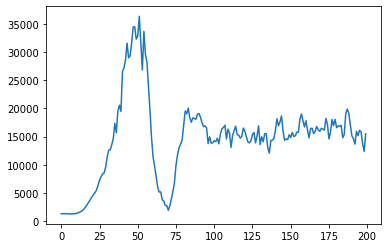

14
Epoch 0/200
99/99 [==============================] - trainLoss: 9.7370  Val_loss: 1615.7382 
Epoch 1/200
99/99 [==============================] - trainLoss: 9.0721  Val_loss: 1617.9414 
Epoch 2/200
99/99 [==============================] - trainLoss: 7.7041  Val_loss: 1621.0793 
Epoch 3/200
99/99 [==============================] - trainLoss: 6.6173  Val_loss: 1636.9073 
Epoch 4/200
99/99 [==============================] - trainLoss: 5.3938  Val_loss: 1677.0983 
Epoch 5/200
99/99 [==============================] - trainLoss: 4.5012  Val_loss: 1718.4344 
Epoch 6/200
99/99 [==============================] - trainLoss: 3.7966  Val_loss: 1773.4937 
Epoch 7/200
99/99 [==============================] - trainLoss: 2.1549  Val_loss: 1824.8831 
Epoch 8/200
99/99 [==============================] - trainLoss: 1.4309  Val_loss: 1906.7412 
Epoch 9/200
99/99 [==============================] - trainLoss: -0.1137  Val_loss: 2048.0923 
Epoch 10/200
99/99 [==============================] - trainLoss: -

99/99 [==============================] - trainLoss: -95.4399  Val_loss: -2347.1589 
Epoch 69/200
99/99 [==============================] - trainLoss: -93.4596  Val_loss: -2383.4998 
Epoch 70/200
99/99 [==============================] - trainLoss: -96.7006  Val_loss: -3877.9529 
Epoch 71/200
99/99 [==============================] - trainLoss: -94.3636  Val_loss: -3337.9524 
Epoch 72/200
99/99 [==============================] - trainLoss: -95.6220  Val_loss: -3324.8738 
Epoch 73/200
99/99 [==============================] - trainLoss: -94.7554  Val_loss: -4481.2061 
Epoch 74/200
99/99 [==============================] - trainLoss: -97.8934  Val_loss: -3242.5039 
Epoch 75/200
99/99 [==============================] - trainLoss: -96.0042  Val_loss: -3299.3042 
Epoch 76/200
99/99 [==============================] - trainLoss: -96.5859  Val_loss: -1427.5334 
Epoch 77/200
99/99 [==============================] - trainLoss: -95.2325  Val_loss: -1109.6332 
Epoch 78/200
99/99 [=======================

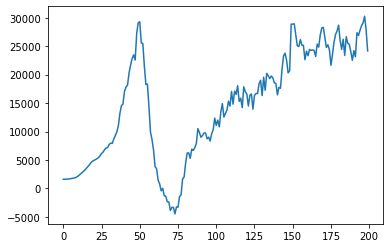

In [4]:
test_loglik_list = []
val_loglik_list = []

for i in range(15):
    
    print(i)

    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state = keras.layers.GRU(hidden_state_size,return_sequences=True,return_state=True)(inputs=x_in,initial_state=hidden_state_in)

    hidden_model = keras.models.Model(inputs=[x_in,x_out,hidden_state_in],outputs=[output2,state])


    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])
    hr_out = keras.layers.Input(shape=[None,num_dims_hr])
    hr_in = keras.layers.Input(shape=[None,num_dims_hr])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state= hidden_model([x_in,x_out,hidden_state_in])

    layer_hr = keras.layers.Dropout(0.3)(output2)
    layer_hr = keras.layers.Dense(16,activation="elu")(layer_hr)
    layer_hr = keras.layers.Dropout(0.3)(layer_hr)
    final_hr_mean = keras.layers.TimeDistributed(keras.layers.Dense(num_dims_hr,bias_initializer='zeros'))(layer_hr) + hr_in
    sigma_mle_hr = (K.mean((final_hr_mean- hr_out)**2))**0.5

    loglik_hr = loglik_gaussian_hr(hr_out,final_hr_mean,sigma_mle_hr)

    nloglik_hr = loss(loglik_hr)

    rnn_training_hr = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[nloglik_hr])
    rnn_generate_hr = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[final_hr_mean,sigma_mle_hr,state])


    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])
    hr_out = keras.layers.Input(shape=[None,num_dims_hr])
    hr_in = keras.layers.Input(shape=[None,num_dims_hr])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state = hidden_model([x_in,x_out,hidden_state_in],training=False)

    layer = keras.layers.Dropout(0.3)(output2)
    layer = keras.layers.Dense(8,activation="elu")(layer)
    layer = keras.layers.Dropout(0.3)(layer)
    final_x_mean = keras.layers.TimeDistributed(keras.layers.Dense(num_dims,bias_initializer='zeros'))(layer) + x_in #this means we predict the residuals (better for learning)
    sigma_mle_x = (K.mean((final_x_mean- x_out)**2))**0.5


    loglik_x = loglik_gaussian_x(x_out,final_x_mean,sigma_mle_x)

    nloglikx = loss(loglik_x)

    rnn_training_x = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[nloglikx])
    rnn_generate_x = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[final_x_mean,sigma_mle_x,state])

    @tf.function
    def train_step(inputs,model):
        """Decorated train_step function which applies a gradient update to the parameters"""
        with tf.GradientTape() as tape:
            loss = model(inputs,training=True)
            loss = tf.add_n([loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    optimizer=keras.optimizers.Adam(learning_rate=0.001)

    def fit_model(input_list,epochs,model,simulator,history,validation_loss
                  ,valid_list,hr_toggle,index,batch_size=32):

        start = time.time()
        K.clear_session()

        batch_loss = []
        batches_per_epoch = int(np.ceil(input_list[0].shape[0]/batch_size))
        
        rnn_generate_x.save("no_tl_models/{}.h5".format(index))
        
        for epoch in range(epochs):
                print("Epoch {}/{}".format(epoch,epochs))
                for i in range(batches_per_epoch):
                    batch_list= create_batch(
                        input_list,batch_size)
                    loss = train_step(batch_list,model)
                    batch_loss.append(loss)
                    average_batch_loss = list_average(batch_loss)
                    print_status_bar(i*batch_size,input_list[0].shape[0],average_batch_loss)

                training_loss_for_epoch = list_average(batch_loss)
                batch_loss = []
                history.append(training_loss_for_epoch)

                sigma_mle = simulator(input_list)[1]

                val_loss = valid_loss(valid_list,simulator=simulator,sigma_x = sigma_mle,hr=hr_toggle)

                validation_loss.append(val_loss)
                if val_loss == min(validation_loss):
                    rnn_generate_x.save("no_tl_models/{}.h5".format(index))

                print_status_bar_epoch(input_list[0].shape[0]
                                 ,input_list[0].shape[0],training_loss_for_epoch,val_loss )

        done = time.time()
        elapsed = done-start
        
        plt.plot(validation_loss,label="validation")
        plt.show()
        
    training_losses = []
    validation_losses = []
    
    fit_model(input_list,200,rnn_training_x,rnn_generate_x,training_losses,validation_losses
              ,valid_list,hr_toggle=False,index=i,batch_size=32)
  

    rnn_generate_x = keras.models.load_model("no_tl_models/{}.h5".format(i))
    
    sigma_x = rnn_generate_x(input_list)[1]
    mean = rnn_generate_x(test_list)[0]
    loglik = np.mean(loglik_gaussian_x(test_nn_output,mean,sigma_x))

    test_loglik_list.append(loglik)
    
    mean = rnn_generate_x(valid_list)[0]
    loglik = np.mean(loglik_gaussian_x(valid_nn_output,mean,sigma_x))

    val_loglik_list.append(loglik)
    
a = np.array(test_loglik_list)
b = np.array(val_loglik_list)
array_loglik = np.stack([b,a],axis=1)
np.save("no_tl_models/loglik_array.npy",array_loglik)


In [5]:
array_loglik

array([[ 1.6753729e+03,  1.3989975e+06],
       [ 2.2109958e+03,  1.9560465e+06],
       [ 1.7163282e+03,  1.6983150e+06],
       [ 2.7829414e+03,  1.4063108e+06],
       [ 4.2518799e+03,  1.4718738e+06],
       [-1.1344034e+03, -9.0117445e+04],
       [ 5.3731134e+02, -2.9211159e+05],
       [ 5.8165449e+03,  2.1455115e+06],
       [-7.6814703e+02, -2.1399133e+05],
       [ 1.4390370e+03,  7.1822850e+05],
       [ 4.1379209e+03,  1.4822712e+06],
       [ 2.5738913e+02,  1.8782148e+06],
       [ 4.0522866e+03,  1.9413259e+06],
       [-1.2877104e+03, -1.9659972e+05],
       [ 4.4812061e+03,  1.6783796e+06]], dtype=float32)

# TL

0
Epoch 0/20
99/99 [==============================] - trainLoss: 28.1946  Val_loss: 1511.9872 
Epoch 1/20
99/99 [==============================] - trainLoss: 20.6384  Val_loss: 1290.7662 
Epoch 2/20
99/99 [==============================] - trainLoss: 12.1494  Val_loss: 1109.4271 
Epoch 3/20
99/99 [==============================] - trainLoss: 4.8178  Val_loss: 978.0610 
Epoch 4/20
99/99 [==============================] - trainLoss: -2.3020  Val_loss: 916.9691 
Epoch 5/20
99/99 [==============================] - trainLoss: -11.0092  Val_loss: 905.8869 
Epoch 6/20
99/99 [==============================] - trainLoss: -17.7586  Val_loss: 956.1406 
Epoch 7/20
99/99 [==============================] - trainLoss: -27.3164  Val_loss: 1134.6870 
Epoch 8/20
99/99 [==============================] - trainLoss: -33.8881  Val_loss: 1391.8813 
Epoch 9/20
99/99 [==============================] - trainLoss: -45.4999  Val_loss: 1854.6831 
Epoch 10/20
99/99 [==============================] - trainLoss: -49.

99/99 [==============================] - trainLoss: -4.4805  Val_loss: 524.7630 
Epoch 20/200
99/99 [==============================] - trainLoss: -5.7648  Val_loss: 475.8034 
Epoch 21/200
99/99 [==============================] - trainLoss: -6.4780  Val_loss: 421.7739 
Epoch 22/200
99/99 [==============================] - trainLoss: -8.2365  Val_loss: 352.4030 
Epoch 23/200
99/99 [==============================] - trainLoss: -8.0616  Val_loss: 268.0667 
Epoch 24/200
99/99 [==============================] - trainLoss: -8.8958  Val_loss: 190.5852 
Epoch 25/200
99/99 [==============================] - trainLoss: -9.0391  Val_loss: 113.1790 
Epoch 26/200
99/99 [==============================] - trainLoss: -10.3721  Val_loss: 48.2900 
Epoch 27/200
99/99 [==============================] - trainLoss: -10.9688  Val_loss: -6.2997 
Epoch 28/200
99/99 [==============================] - trainLoss: -11.6872  Val_loss: -63.7356 
Epoch 29/200
99/99 [==============================] - trainLoss: -11.857

99/99 [==============================] - trainLoss: -28.4042  Val_loss: -1155.4017 
Epoch 48/200
99/99 [==============================] - trainLoss: -29.7606  Val_loss: -1300.0914 
Epoch 49/200
99/99 [==============================] - trainLoss: -30.6319  Val_loss: -1429.5215 
Epoch 50/200
99/99 [==============================] - trainLoss: -31.9408  Val_loss: -1533.3428 
Epoch 51/200
99/99 [==============================] - trainLoss: -33.7990  Val_loss: -1503.2469 
Epoch 52/200
99/99 [==============================] - trainLoss: -34.0995  Val_loss: -1564.1321 
Epoch 53/200
99/99 [==============================] - trainLoss: -35.9592  Val_loss: -1710.5693 
Epoch 54/200
99/99 [==============================] - trainLoss: -36.9408  Val_loss: -1839.3309 
Epoch 55/200
99/99 [==============================] - trainLoss: -38.8533  Val_loss: -1796.5853 
Epoch 56/200
99/99 [==============================] - trainLoss: -40.6839  Val_loss: -2142.3362 
Epoch 57/200
99/99 [=======================

99/99 [==============================] - trainLoss: -97.0167  Val_loss: -8890.0156 
Epoch 164/200
99/99 [==============================] - trainLoss: -96.9870  Val_loss: -8854.7656 
Epoch 165/200
99/99 [==============================] - trainLoss: -97.5195  Val_loss: -8707.4648 
Epoch 166/200
99/99 [==============================] - trainLoss: -97.5796  Val_loss: -8853.5850 
Epoch 167/200
99/99 [==============================] - trainLoss: -98.2489  Val_loss: -9030.5410 
Epoch 168/200
99/99 [==============================] - trainLoss: -97.6385  Val_loss: -8782.6367 
Epoch 169/200
99/99 [==============================] - trainLoss: -98.4286  Val_loss: -8707.9678 
Epoch 170/200
99/99 [==============================] - trainLoss: -97.3855  Val_loss: -8752.6934 
Epoch 171/200
99/99 [==============================] - trainLoss: -97.9984  Val_loss: -8561.8750 
Epoch 172/200
99/99 [==============================] - trainLoss: -96.6007  Val_loss: -8497.9238 
Epoch 173/200
99/99 [=============

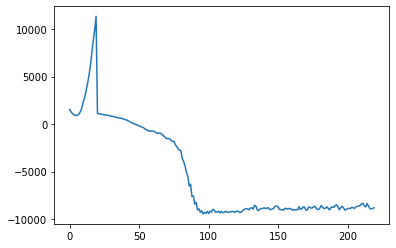

1
Epoch 0/20
99/99 [==============================] - trainLoss: 10.2197  Val_loss: -2186.4194 
Epoch 1/20
99/99 [==============================] - trainLoss: 0.4327  Val_loss: -2772.8879 
Epoch 2/20
99/99 [==============================] - trainLoss: -8.3467  Val_loss: -3276.3774 
Epoch 3/20
99/99 [==============================] - trainLoss: -19.6955  Val_loss: -3685.3423 
Epoch 4/20
99/99 [==============================] - trainLoss: -24.3486  Val_loss: -4061.0913 
Epoch 5/20
99/99 [==============================] - trainLoss: -34.5637  Val_loss: -4340.1069 
Epoch 6/20
99/99 [==============================] - trainLoss: -39.9152  Val_loss: -4532.8506 
Epoch 7/20
99/99 [==============================] - trainLoss: -49.6411  Val_loss: -4623.7085 
Epoch 8/20
99/99 [==============================] - trainLoss: -57.1234  Val_loss: -4623.4336 
Epoch 9/20
99/99 [==============================] - trainLoss: -63.8437  Val_loss: -4554.7681 
Epoch 10/20
99/99 [==============================] -

99/99 [==============================] - trainLoss: -96.6995  Val_loss: -8583.7295 
Epoch 105/200
99/99 [==============================] - trainLoss: -98.2188  Val_loss: -8474.6406 
Epoch 106/200
99/99 [==============================] - trainLoss: -98.1657  Val_loss: -8320.9668 
Epoch 107/200
99/99 [==============================] - trainLoss: -97.6215  Val_loss: -8781.6826 
Epoch 108/200
99/99 [==============================] - trainLoss: -95.3564  Val_loss: -8875.0156 
Epoch 109/200
99/99 [==============================] - trainLoss: -97.9613  Val_loss: -8254.7637 
Epoch 110/200
99/99 [==============================] - trainLoss: -97.9163  Val_loss: -8764.6855 
Epoch 111/200
99/99 [==============================] - trainLoss: -98.1427  Val_loss: -8941.5439 
Epoch 112/200
99/99 [==============================] - trainLoss: -98.9668  Val_loss: -8693.7275 
Epoch 113/200
99/99 [==============================] - trainLoss: -97.2861  Val_loss: -8752.6328 
Epoch 114/200
99/99 [=============

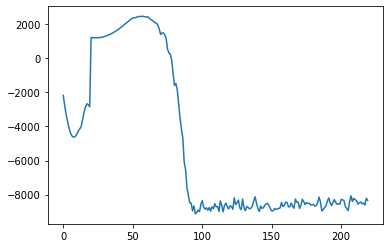

2
Epoch 0/20
99/99 [==============================] - trainLoss: 30.5286  Val_loss: 159.1742 
Epoch 1/20
99/99 [==============================] - trainLoss: 20.8818  Val_loss: -423.0255 
Epoch 2/20
99/99 [==============================] - trainLoss: 11.1453  Val_loss: -912.7476 
Epoch 3/20
99/99 [==============================] - trainLoss: 0.3740  Val_loss: -1358.0615 
Epoch 4/20
99/99 [==============================] - trainLoss: -8.9588  Val_loss: -1774.8599 
Epoch 5/20
99/99 [==============================] - trainLoss: -14.1255  Val_loss: -2173.0420 
Epoch 6/20
99/99 [==============================] - trainLoss: -25.0451  Val_loss: -2496.9846 
Epoch 7/20
99/99 [==============================] - trainLoss: -32.0514  Val_loss: -2751.8606 
Epoch 8/20
99/99 [==============================] - trainLoss: -42.7590  Val_loss: -2918.4956 
Epoch 9/20
99/99 [==============================] - trainLoss: -49.8513  Val_loss: -2989.8779 
Epoch 10/20
99/99 [==============================] - train

99/99 [==============================] - trainLoss: -4.4614  Val_loss: 2704.6187 
Epoch 13/200
99/99 [==============================] - trainLoss: -5.8052  Val_loss: 2732.5100 
Epoch 14/200
99/99 [==============================] - trainLoss: -5.9623  Val_loss: 2777.4116 
Epoch 15/200
99/99 [==============================] - trainLoss: -6.3459  Val_loss: 2809.1873 
Epoch 16/200
99/99 [==============================] - trainLoss: -6.6143  Val_loss: 2829.2051 
Epoch 17/200
99/99 [==============================] - trainLoss: -8.0188  Val_loss: 2834.9185 
Epoch 18/200
99/99 [==============================] - trainLoss: -7.9398  Val_loss: 2840.8835 
Epoch 19/200
99/99 [==============================] - trainLoss: -9.6026  Val_loss: 2833.5002 
Epoch 20/200
99/99 [==============================] - trainLoss: -10.3061  Val_loss: 2811.0183 
Epoch 21/200
99/99 [==============================] - trainLoss: -10.5213  Val_loss: 2756.8154 
Epoch 22/200
99/99 [==============================] - trainLo

99/99 [==============================] - trainLoss: -100.6447  Val_loss: -8725.8662 
Epoch 172/200
99/99 [==============================] - trainLoss: -98.4253  Val_loss: -8626.5078 
Epoch 173/200
99/99 [==============================] - trainLoss: -99.6123  Val_loss: -8374.9424 
Epoch 174/200
99/99 [==============================] - trainLoss: -97.8068  Val_loss: -8740.9248 
Epoch 175/200
99/99 [==============================] - trainLoss: -99.6873  Val_loss: -8862.4844 
Epoch 176/200
99/99 [==============================] - trainLoss: -98.4776  Val_loss: -8374.3076 
Epoch 177/200
99/99 [==============================] - trainLoss: -97.5852  Val_loss: -8507.7510 
Epoch 178/200
99/99 [==============================] - trainLoss: -99.3439  Val_loss: -8556.0879 
Epoch 179/200
99/99 [==============================] - trainLoss: -97.7424  Val_loss: -8223.9775 
Epoch 180/200
99/99 [==============================] - trainLoss: -100.1228  Val_loss: -8517.3506 
Epoch 181/200
99/99 [===========

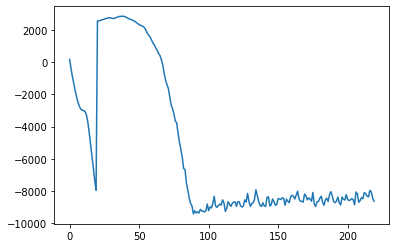

3
Epoch 0/20
99/99 [==============================] - trainLoss: 26.8871  Val_loss: -631.5390 
Epoch 1/20
99/99 [==============================] - trainLoss: 18.4501  Val_loss: -1173.2382 
Epoch 2/20
99/99 [==============================] - trainLoss: 9.3484  Val_loss: -1579.2672 
Epoch 3/20
99/99 [==============================] - trainLoss: 0.1626  Val_loss: -1815.5442 
Epoch 4/20
99/99 [==============================] - trainLoss: -5.2921  Val_loss: -1915.8903 
Epoch 5/20
99/99 [==============================] - trainLoss: -16.6063  Val_loss: -1814.9735 
Epoch 6/20
99/99 [==============================] - trainLoss: -25.5037  Val_loss: -1523.6429 
Epoch 7/20
99/99 [==============================] - trainLoss: -36.8840  Val_loss: -1005.9311 
Epoch 8/20
99/99 [==============================] - trainLoss: -41.9380  Val_loss: -332.0587 
Epoch 9/20
99/99 [==============================] - trainLoss: -54.5118  Val_loss: 506.4174 
Epoch 10/20
99/99 [==============================] - trainL

99/99 [==============================] - trainLoss: -42.3462  Val_loss: 394.7378 
Epoch 53/200
99/99 [==============================] - trainLoss: -44.3919  Val_loss: 307.6764 
Epoch 54/200
99/99 [==============================] - trainLoss: -46.9086  Val_loss: -102.1283 
Epoch 55/200
99/99 [==============================] - trainLoss: -48.3024  Val_loss: -630.1086 
Epoch 56/200
99/99 [==============================] - trainLoss: -49.9999  Val_loss: -1507.0074 
Epoch 57/200
99/99 [==============================] - trainLoss: -52.3548  Val_loss: -2385.7590 
Epoch 58/200
99/99 [==============================] - trainLoss: -54.1354  Val_loss: -2552.3730 
Epoch 59/200
99/99 [==============================] - trainLoss: -57.7519  Val_loss: -2543.5144 
Epoch 60/200
99/99 [==============================] - trainLoss: -60.8325  Val_loss: -3775.4307 
Epoch 61/200
99/99 [==============================] - trainLoss: -63.5663  Val_loss: -3834.9829 
Epoch 62/200
99/99 [=============================

99/99 [==============================] - trainLoss: -98.3461  Val_loss: -9018.4814 
Epoch 95/200
99/99 [==============================] - trainLoss: -98.2183  Val_loss: -8973.6904 
Epoch 96/200
99/99 [==============================] - trainLoss: -98.4261  Val_loss: -8903.7344 
Epoch 97/200
99/99 [==============================] - trainLoss: -97.3929  Val_loss: -8380.7490 
Epoch 98/200
99/99 [==============================] - trainLoss: -96.7864  Val_loss: -8489.5244 
Epoch 99/200
99/99 [==============================] - trainLoss: -97.4776  Val_loss: -8620.5254 
Epoch 100/200
99/99 [==============================] - trainLoss: -96.6987  Val_loss: -8473.5693 
Epoch 101/200
99/99 [==============================] - trainLoss: -97.4112  Val_loss: -8504.2139 
Epoch 102/200
99/99 [==============================] - trainLoss: -97.1539  Val_loss: -8548.9277 
Epoch 103/200
99/99 [==============================] - trainLoss: -97.5564  Val_loss: -8412.8867 
Epoch 104/200
99/99 [==================

99/99 [==============================] - trainLoss: -99.8236  Val_loss: -8571.5215 
Epoch 177/200
99/99 [==============================] - trainLoss: -98.4510  Val_loss: -8550.2344 
Epoch 178/200
99/99 [==============================] - trainLoss: -98.6972  Val_loss: -8587.7178 
Epoch 179/200
99/99 [==============================] - trainLoss: -98.5396  Val_loss: -8934.2832 
Epoch 180/200
99/99 [==============================] - trainLoss: -97.7156  Val_loss: -8927.4121 
Epoch 181/200
99/99 [==============================] - trainLoss: -98.5341  Val_loss: -8916.5518 
Epoch 182/200
99/99 [==============================] - trainLoss: -98.0867  Val_loss: -8440.7031 
Epoch 183/200
99/99 [==============================] - trainLoss: -98.6489  Val_loss: -8318.8799 
Epoch 184/200
99/99 [==============================] - trainLoss: -97.6419  Val_loss: -8653.0059 
Epoch 185/200
99/99 [==============================] - trainLoss: -97.1011  Val_loss: -8852.3281 
Epoch 186/200
99/99 [=============

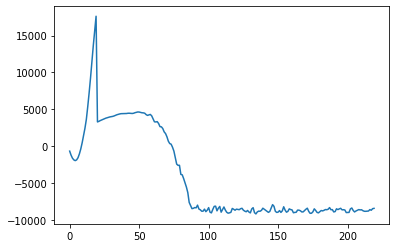

4
Epoch 0/20
99/99 [==============================] - trainLoss: 26.9951  Val_loss: 1310.3550 
Epoch 1/20
99/99 [==============================] - trainLoss: 17.2656  Val_loss: 1084.7046 
Epoch 2/20
99/99 [==============================] - trainLoss: 7.5048  Val_loss: 1001.9009 
Epoch 3/20
99/99 [==============================] - trainLoss: -2.8621  Val_loss: 1077.3746 
Epoch 4/20
99/99 [==============================] - trainLoss: -9.6217  Val_loss: 1263.8389 
Epoch 5/20
99/99 [==============================] - trainLoss: -17.8202  Val_loss: 1564.4113 
Epoch 6/20
99/99 [==============================] - trainLoss: -27.4001  Val_loss: 1959.4229 
Epoch 7/20
99/99 [==============================] - trainLoss: -37.2924  Val_loss: 2381.4512 
Epoch 8/20
99/99 [==============================] - trainLoss: -42.4959  Val_loss: 2872.2981 
Epoch 9/20
99/99 [==============================] - trainLoss: -50.9765  Val_loss: 3366.6716 
Epoch 10/20
99/99 [==============================] - trainLoss: 

99/99 [==============================] - trainLoss: -42.3998  Val_loss: 5616.9390 
Epoch 57/200
99/99 [==============================] - trainLoss: -44.6298  Val_loss: 5271.1465 
Epoch 58/200
99/99 [==============================] - trainLoss: -45.9214  Val_loss: 4490.7480 
Epoch 59/200
99/99 [==============================] - trainLoss: -48.0960  Val_loss: 3660.0032 
Epoch 60/200
99/99 [==============================] - trainLoss: -49.9863  Val_loss: 3317.1843 
Epoch 61/200
99/99 [==============================] - trainLoss: -52.4369  Val_loss: 3364.8838 
Epoch 62/200
99/99 [==============================] - trainLoss: -54.0773  Val_loss: 1678.2316 
Epoch 63/200
99/99 [==============================] - trainLoss: -57.0500  Val_loss: 279.1273 
Epoch 64/200
99/99 [==============================] - trainLoss: -59.5894  Val_loss: -935.8441 
Epoch 65/200
99/99 [==============================] - trainLoss: -62.3168  Val_loss: -3202.6907 
Epoch 66/200
99/99 [==============================] -

99/99 [==============================] - trainLoss: -97.7972  Val_loss: -9094.1240 
Epoch 110/200
99/99 [==============================] - trainLoss: -96.0527  Val_loss: -9302.1436 
Epoch 111/200
99/99 [==============================] - trainLoss: -98.1539  Val_loss: -9252.0186 
Epoch 112/200
99/99 [==============================] - trainLoss: -97.6512  Val_loss: -9074.7451 
Epoch 113/200
99/99 [==============================] - trainLoss: -98.7855  Val_loss: -9094.2314 
Epoch 114/200
99/99 [==============================] - trainLoss: -96.4918  Val_loss: -9027.1973 
Epoch 115/200
99/99 [==============================] - trainLoss: -97.6434  Val_loss: -9208.1201 
Epoch 116/200
99/99 [==============================] - trainLoss: -96.6398  Val_loss: -9272.9590 
Epoch 117/200
99/99 [==============================] - trainLoss: -96.6332  Val_loss: -9069.5830 
Epoch 118/200
99/99 [==============================] - trainLoss: -96.7535  Val_loss: -9052.9668 
Epoch 119/200
99/99 [=============

99/99 [==============================] - trainLoss: -98.1867  Val_loss: -9055.5918 
Epoch 195/200
99/99 [==============================] - trainLoss: -99.4112  Val_loss: -9292.3457 
Epoch 196/200
99/99 [==============================] - trainLoss: -98.3099  Val_loss: -9286.2109 
Epoch 197/200
99/99 [==============================] - trainLoss: -98.1776  Val_loss: -9176.2422 
Epoch 198/200
99/99 [==============================] - trainLoss: -98.6282  Val_loss: -9140.2109 
Epoch 199/200
99/99 [==============================] - trainLoss: -98.1072  Val_loss: -9049.1777 


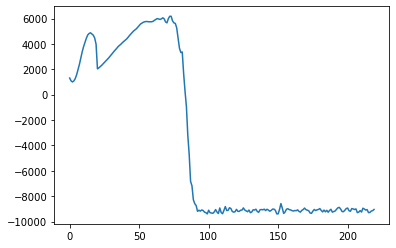

5
Epoch 0/20
99/99 [==============================] - trainLoss: 19.9991  Val_loss: -1415.8368 
Epoch 1/20
99/99 [==============================] - trainLoss: 10.3064  Val_loss: -1907.8000 
Epoch 2/20
99/99 [==============================] - trainLoss: 2.9064  Val_loss: -2302.8257 
Epoch 3/20
99/99 [==============================] - trainLoss: -8.0311  Val_loss: -2628.3633 
Epoch 4/20
99/99 [==============================] - trainLoss: -13.7392  Val_loss: -2861.8499 
Epoch 5/20
99/99 [==============================] - trainLoss: -23.0034  Val_loss: -2969.6404 
Epoch 6/20
99/99 [==============================] - trainLoss: -29.1316  Val_loss: -2961.7920 
Epoch 7/20
99/99 [==============================] - trainLoss: -40.3039  Val_loss: -2832.6907 
Epoch 8/20
99/99 [==============================] - trainLoss: -44.8474  Val_loss: -2540.9243 
Epoch 9/20
99/99 [==============================] - trainLoss: -57.0597  Val_loss: -2101.7993 
Epoch 10/20
99/99 [==============================] - 

99/99 [==============================] - trainLoss: -28.5627  Val_loss: 2759.9360 
Epoch 48/200
99/99 [==============================] - trainLoss: -28.4732  Val_loss: 2507.7693 
Epoch 49/200
99/99 [==============================] - trainLoss: -30.3455  Val_loss: 2543.4270 
Epoch 50/200
99/99 [==============================] - trainLoss: -31.4195  Val_loss: 2499.7834 
Epoch 51/200
99/99 [==============================] - trainLoss: -33.2800  Val_loss: 2316.9104 
Epoch 52/200
99/99 [==============================] - trainLoss: -34.4036  Val_loss: 2140.2881 
Epoch 53/200
99/99 [==============================] - trainLoss: -36.1340  Val_loss: 2112.9448 
Epoch 54/200
99/99 [==============================] - trainLoss: -37.0003  Val_loss: 1904.7554 
Epoch 55/200
99/99 [==============================] - trainLoss: -38.0560  Val_loss: 1691.6952 
Epoch 56/200
99/99 [==============================] - trainLoss: -40.3891  Val_loss: 1835.9924 
Epoch 57/200
99/99 [==============================] -

99/99 [==============================] - trainLoss: -98.8218  Val_loss: -8997.3643 
Epoch 109/200
99/99 [==============================] - trainLoss: -97.2906  Val_loss: -9035.5635 
Epoch 110/200
99/99 [==============================] - trainLoss: -96.5063  Val_loss: -9018.8350 
Epoch 111/200
99/99 [==============================] - trainLoss: -95.7079  Val_loss: -8792.0635 
Epoch 112/200
99/99 [==============================] - trainLoss: -97.6819  Val_loss: -8717.4678 
Epoch 113/200
99/99 [==============================] - trainLoss: -96.8275  Val_loss: -8957.3486 
Epoch 114/200
99/99 [==============================] - trainLoss: -97.9647  Val_loss: -9119.0195 
Epoch 115/200
99/99 [==============================] - trainLoss: -98.9516  Val_loss: -9118.8936 
Epoch 116/200
99/99 [==============================] - trainLoss: -97.8572  Val_loss: -9048.9404 
Epoch 117/200
99/99 [==============================] - trainLoss: -97.3846  Val_loss: -9051.2070 
Epoch 118/200
99/99 [=============

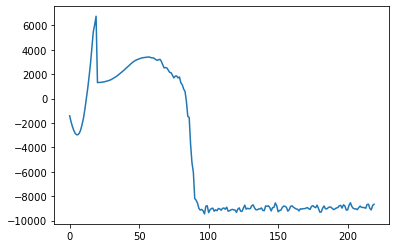

6
Epoch 0/20
99/99 [==============================] - trainLoss: 23.3928  Val_loss: 1122.4592 
Epoch 1/20
99/99 [==============================] - trainLoss: 14.0135  Val_loss: 616.9949 
Epoch 2/20
99/99 [==============================] - trainLoss: 5.2789  Val_loss: 112.6492 
Epoch 3/20
99/99 [==============================] - trainLoss: -2.8073  Val_loss: -407.6478 
Epoch 4/20
99/99 [==============================] - trainLoss: -10.9339  Val_loss: -926.8621 
Epoch 5/20
99/99 [==============================] - trainLoss: -15.7037  Val_loss: -1468.5339 
Epoch 6/20
99/99 [==============================] - trainLoss: -22.4509  Val_loss: -2065.5198 
Epoch 7/20
99/99 [==============================] - trainLoss: -31.1807  Val_loss: -2637.9958 
Epoch 8/20
99/99 [==============================] - trainLoss: -36.0642  Val_loss: -3091.7949 
Epoch 9/20
99/99 [==============================] - trainLoss: -42.8571  Val_loss: -3521.7048 
Epoch 10/20
99/99 [==============================] - trainLo

99/99 [==============================] - trainLoss: -11.9199  Val_loss: 684.2039 
Epoch 35/200
99/99 [==============================] - trainLoss: -13.2667  Val_loss: 602.1724 
Epoch 36/200
99/99 [==============================] - trainLoss: -14.0867  Val_loss: 522.8920 
Epoch 37/200
99/99 [==============================] - trainLoss: -15.2056  Val_loss: 407.9709 
Epoch 38/200
99/99 [==============================] - trainLoss: -16.5350  Val_loss: 362.6385 
Epoch 39/200
99/99 [==============================] - trainLoss: -17.9143  Val_loss: 289.8580 
Epoch 40/200
99/99 [==============================] - trainLoss: -18.1868  Val_loss: 175.3122 
Epoch 41/200
99/99 [==============================] - trainLoss: -18.8723  Val_loss: 32.4297 
Epoch 42/200
99/99 [==============================] - trainLoss: -20.6414  Val_loss: -88.4115 
Epoch 43/200
99/99 [==============================] - trainLoss: -21.7627  Val_loss: -130.4927 
Epoch 44/200
99/99 [==============================] - trainLoss

99/99 [==============================] - trainLoss: -97.4259  Val_loss: -9368.4951 
Epoch 92/200
99/99 [==============================] - trainLoss: -97.8042  Val_loss: -9317.4521 
Epoch 93/200
99/99 [==============================] - trainLoss: -96.2653  Val_loss: -9315.2549 
Epoch 94/200
99/99 [==============================] - trainLoss: -97.9705  Val_loss: -9522.1357 
Epoch 95/200
99/99 [==============================] - trainLoss: -98.6784  Val_loss: -9369.3096 
Epoch 96/200
99/99 [==============================] - trainLoss: -96.0852  Val_loss: -9361.1172 
Epoch 97/200
99/99 [==============================] - trainLoss: -97.9405  Val_loss: -9280.2764 
Epoch 98/200
99/99 [==============================] - trainLoss: -95.0875  Val_loss: -9323.8135 
Epoch 99/200
99/99 [==============================] - trainLoss: -97.9021  Val_loss: -9403.7969 
Epoch 100/200
99/99 [==============================] - trainLoss: -96.2661  Val_loss: -9289.8242 
Epoch 101/200
99/99 [=====================

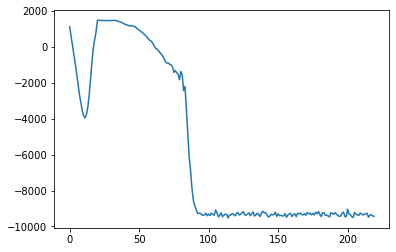

7
Epoch 0/20
99/99 [==============================] - trainLoss: 30.7145  Val_loss: -737.6293 
Epoch 1/20
99/99 [==============================] - trainLoss: 27.1883  Val_loss: -1249.7317 
Epoch 2/20
99/99 [==============================] - trainLoss: 18.1617  Val_loss: -1693.0469 
Epoch 3/20
99/99 [==============================] - trainLoss: 7.7022  Val_loss: -2060.1528 
Epoch 4/20
99/99 [==============================] - trainLoss: -2.6778  Val_loss: -2328.3618 
Epoch 5/20
99/99 [==============================] - trainLoss: -9.0234  Val_loss: -2487.3262 
Epoch 6/20
99/99 [==============================] - trainLoss: -16.1238  Val_loss: -2564.8474 
Epoch 7/20
99/99 [==============================] - trainLoss: -27.1429  Val_loss: -2562.7163 
Epoch 8/20
99/99 [==============================] - trainLoss: -34.8812  Val_loss: -2489.3057 
Epoch 9/20
99/99 [==============================] - trainLoss: -41.8169  Val_loss: -2342.4998 
Epoch 10/20
99/99 [==============================] - tra

99/99 [==============================] - trainLoss: -24.7682  Val_loss: -1025.8600 
Epoch 46/200
99/99 [==============================] - trainLoss: -26.3574  Val_loss: -1182.4171 
Epoch 47/200
99/99 [==============================] - trainLoss: -27.5814  Val_loss: -1382.0382 
Epoch 48/200
99/99 [==============================] - trainLoss: -28.5595  Val_loss: -1543.5486 
Epoch 49/200
99/99 [==============================] - trainLoss: -30.5029  Val_loss: -1713.9617 
Epoch 50/200
99/99 [==============================] - trainLoss: -31.6088  Val_loss: -1902.1154 
Epoch 51/200
99/99 [==============================] - trainLoss: -32.3119  Val_loss: -2121.9565 
Epoch 52/200
99/99 [==============================] - trainLoss: -33.9338  Val_loss: -2253.6858 
Epoch 53/200
99/99 [==============================] - trainLoss: -35.2432  Val_loss: -2335.9128 
Epoch 54/200
99/99 [==============================] - trainLoss: -37.7393  Val_loss: -2505.0332 
Epoch 55/200
99/99 [=======================

99/99 [==============================] - trainLoss: -98.1118  Val_loss: -8611.2539 
Epoch 163/200
99/99 [==============================] - trainLoss: -96.5940  Val_loss: -8678.9580 
Epoch 164/200
99/99 [==============================] - trainLoss: -98.7644  Val_loss: -8996.0029 
Epoch 165/200
99/99 [==============================] - trainLoss: -99.4134  Val_loss: -9372.5078 
Epoch 166/200
99/99 [==============================] - trainLoss: -98.0096  Val_loss: -9336.7207 
Epoch 167/200
99/99 [==============================] - trainLoss: -97.0548  Val_loss: -9016.7246 
Epoch 168/200
99/99 [==============================] - trainLoss: -97.2250  Val_loss: -8706.5859 
Epoch 169/200
99/99 [==============================] - trainLoss: -96.4127  Val_loss: -8785.6777 
Epoch 170/200
99/99 [==============================] - trainLoss: -98.9972  Val_loss: -9011.3203 
Epoch 171/200
99/99 [==============================] - trainLoss: -96.8576  Val_loss: -8857.1621 
Epoch 172/200
99/99 [=============

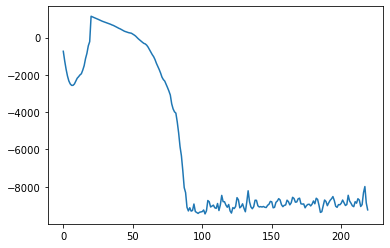

8
Epoch 0/20
99/99 [==============================] - trainLoss: 20.3436  Val_loss: 1086.3347 
Epoch 1/20
99/99 [==============================] - trainLoss: 13.0488  Val_loss: 774.7271 
Epoch 2/20
99/99 [==============================] - trainLoss: 3.1350  Val_loss: 526.5760 
Epoch 3/20
99/99 [==============================] - trainLoss: -2.4741  Val_loss: 276.5332 
Epoch 4/20
99/99 [==============================] - trainLoss: -13.8562  Val_loss: 88.9351 
Epoch 5/20
99/99 [==============================] - trainLoss: -19.4661  Val_loss: -49.4892 
Epoch 6/20
99/99 [==============================] - trainLoss: -29.6006  Val_loss: -51.5916 
Epoch 7/20
99/99 [==============================] - trainLoss: -33.7839  Val_loss: -6.7556 
Epoch 8/20
99/99 [==============================] - trainLoss: -42.6080  Val_loss: 127.5158 
Epoch 9/20
99/99 [==============================] - trainLoss: -51.8849  Val_loss: 435.7026 
Epoch 10/20
99/99 [==============================] - trainLoss: -58.6315  

99/99 [==============================] - trainLoss: -21.8611  Val_loss: -278.1958 
Epoch 37/200
99/99 [==============================] - trainLoss: -21.2886  Val_loss: -364.0472 
Epoch 38/200
99/99 [==============================] - trainLoss: -23.4563  Val_loss: -464.9560 
Epoch 39/200
99/99 [==============================] - trainLoss: -23.2830  Val_loss: -578.8865 
Epoch 40/200
99/99 [==============================] - trainLoss: -25.4990  Val_loss: -701.9547 
Epoch 41/200
99/99 [==============================] - trainLoss: -26.2661  Val_loss: -823.0620 
Epoch 42/200
99/99 [==============================] - trainLoss: -27.1277  Val_loss: -884.8367 
Epoch 43/200
99/99 [==============================] - trainLoss: -27.6190  Val_loss: -950.8759 
Epoch 44/200
99/99 [==============================] - trainLoss: -29.5346  Val_loss: -1058.5920 
Epoch 45/200
99/99 [==============================] - trainLoss: -30.4748  Val_loss: -1244.5509 
Epoch 46/200
99/99 [==============================]

99/99 [==============================] - trainLoss: -56.6038  Val_loss: -5364.3726 
Epoch 62/200
99/99 [==============================] - trainLoss: -58.2703  Val_loss: -5849.1509 
Epoch 63/200
99/99 [==============================] - trainLoss: -61.4121  Val_loss: -5991.4619 
Epoch 64/200
99/99 [==============================] - trainLoss: -64.5294  Val_loss: -6990.4824 
Epoch 65/200
99/99 [==============================] - trainLoss: -67.9901  Val_loss: -7366.4175 
Epoch 66/200
99/99 [==============================] - trainLoss: -70.9530  Val_loss: -7985.4785 
Epoch 67/200
99/99 [==============================] - trainLoss: -74.6792  Val_loss: -8184.3672 
Epoch 68/200
99/99 [==============================] - trainLoss: -78.8641  Val_loss: -8837.0371 
Epoch 69/200
99/99 [==============================] - trainLoss: -81.9515  Val_loss: -9051.4404 
Epoch 70/200
99/99 [==============================] - trainLoss: -85.7223  Val_loss: -9193.5166 
Epoch 71/200
99/99 [=======================

99/99 [==============================] - trainLoss: -96.2492  Val_loss: -9006.5088 
Epoch 115/200
99/99 [==============================] - trainLoss: -97.8649  Val_loss: -8609.9531 
Epoch 116/200
99/99 [==============================] - trainLoss: -98.1319  Val_loss: -8749.1953 
Epoch 117/200
99/99 [==============================] - trainLoss: -98.8163  Val_loss: -8899.3975 
Epoch 118/200
99/99 [==============================] - trainLoss: -97.4783  Val_loss: -9110.3691 
Epoch 119/200
99/99 [==============================] - trainLoss: -96.5449  Val_loss: -8940.2148 
Epoch 120/200
99/99 [==============================] - trainLoss: -98.7718  Val_loss: -8986.7695 
Epoch 121/200
99/99 [==============================] - trainLoss: -98.5119  Val_loss: -9005.5605 
Epoch 122/200
99/99 [==============================] - trainLoss: -98.9245  Val_loss: -8999.5586 
Epoch 123/200
99/99 [==============================] - trainLoss: -98.3631  Val_loss: -9003.3262 
Epoch 124/200
99/99 [=============

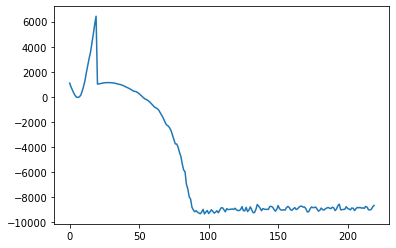

9
Epoch 0/20
99/99 [==============================] - trainLoss: 10.4185  Val_loss: -1295.9718 
Epoch 1/20
99/99 [==============================] - trainLoss: -3.6723  Val_loss: -1769.8896 
Epoch 2/20
99/99 [==============================] - trainLoss: -9.9318  Val_loss: -2165.5979 
Epoch 3/20
99/99 [==============================] - trainLoss: -20.4896  Val_loss: -2526.4368 
Epoch 4/20
99/99 [==============================] - trainLoss: -26.1417  Val_loss: -2932.4761 
Epoch 5/20
99/99 [==============================] - trainLoss: -39.8954  Val_loss: -3272.2468 
Epoch 6/20
99/99 [==============================] - trainLoss: -43.6729  Val_loss: -3594.8210 
Epoch 7/20
99/99 [==============================] - trainLoss: -55.4089  Val_loss: -4022.3740 
Epoch 8/20
99/99 [==============================] - trainLoss: -59.7070  Val_loss: -4543.3745 
Epoch 9/20
99/99 [==============================] - trainLoss: -73.5323  Val_loss: -5045.9194 
Epoch 10/20
99/99 [==============================] 

99/99 [==============================] - trainLoss: -3.5902  Val_loss: -437.5909 
Epoch 18/200
99/99 [==============================] - trainLoss: -4.1553  Val_loss: -469.4051 
Epoch 19/200
99/99 [==============================] - trainLoss: -4.6829  Val_loss: -499.6715 
Epoch 20/200
99/99 [==============================] - trainLoss: -6.4530  Val_loss: -528.9504 
Epoch 21/200
99/99 [==============================] - trainLoss: -5.8339  Val_loss: -566.6128 
Epoch 22/200
99/99 [==============================] - trainLoss: -6.9417  Val_loss: -602.3942 
Epoch 23/200
99/99 [==============================] - trainLoss: -8.3392  Val_loss: -632.0196 
Epoch 24/200
99/99 [==============================] - trainLoss: -8.2175  Val_loss: -659.5903 
Epoch 25/200
99/99 [==============================] - trainLoss: -8.9740  Val_loss: -683.6016 
Epoch 26/200
99/99 [==============================] - trainLoss: -9.8680  Val_loss: -714.5992 
Epoch 27/200
99/99 [==============================] - trainLoss

99/99 [==============================] - trainLoss: -96.3640  Val_loss: -9457.7188 
Epoch 85/200
99/99 [==============================] - trainLoss: -96.3195  Val_loss: -9441.8828 
Epoch 86/200
99/99 [==============================] - trainLoss: -96.2924  Val_loss: -9416.5547 
Epoch 87/200
99/99 [==============================] - trainLoss: -96.7315  Val_loss: -9408.9258 
Epoch 88/200
99/99 [==============================] - trainLoss: -96.9486  Val_loss: -9488.0918 
Epoch 89/200
99/99 [==============================] - trainLoss: -98.3682  Val_loss: -9430.1123 
Epoch 90/200
99/99 [==============================] - trainLoss: -96.6706  Val_loss: -9258.1484 
Epoch 91/200
99/99 [==============================] - trainLoss: -97.8956  Val_loss: -9440.4668 
Epoch 92/200
99/99 [==============================] - trainLoss: -97.4942  Val_loss: -9430.8096 
Epoch 93/200
99/99 [==============================] - trainLoss: -98.3656  Val_loss: -9540.1982 
Epoch 94/200
99/99 [=======================

99/99 [==============================] - trainLoss: -97.1018  Val_loss: -9194.8809 
Epoch 164/200
99/99 [==============================] - trainLoss: -97.8089  Val_loss: -9137.7861 
Epoch 165/200
99/99 [==============================] - trainLoss: -98.3282  Val_loss: -9233.9541 
Epoch 166/200
99/99 [==============================] - trainLoss: -98.2879  Val_loss: -9369.5117 
Epoch 167/200
99/99 [==============================] - trainLoss: -98.5114  Val_loss: -9437.3193 
Epoch 168/200
99/99 [==============================] - trainLoss: -99.0450  Val_loss: -9470.6650 
Epoch 169/200
99/99 [==============================] - trainLoss: -98.2298  Val_loss: -9443.1738 
Epoch 170/200
99/99 [==============================] - trainLoss: -98.5226  Val_loss: -9285.0137 
Epoch 171/200
99/99 [==============================] - trainLoss: -97.5201  Val_loss: -9215.0166 
Epoch 172/200
99/99 [==============================] - trainLoss: -96.8565  Val_loss: -9192.6934 
Epoch 173/200
99/99 [=============

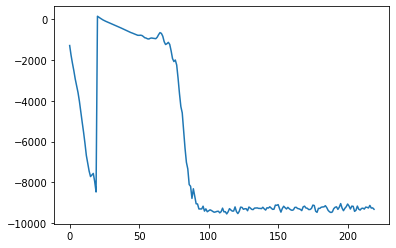

10
Epoch 0/20
99/99 [==============================] - trainLoss: 22.0352  Val_loss: -1694.1068 
Epoch 1/20
99/99 [==============================] - trainLoss: 12.2426  Val_loss: -2112.0715 
Epoch 2/20
99/99 [==============================] - trainLoss: 6.8632  Val_loss: -2400.1943 
Epoch 3/20
99/99 [==============================] - trainLoss: -3.5705  Val_loss: -2512.0430 
Epoch 4/20
99/99 [==============================] - trainLoss: -14.1424  Val_loss: -2500.8870 
Epoch 5/20
99/99 [==============================] - trainLoss: -18.8947  Val_loss: -2404.2498 
Epoch 6/20
99/99 [==============================] - trainLoss: -29.7223  Val_loss: -2207.6006 
Epoch 7/20
99/99 [==============================] - trainLoss: -37.0072  Val_loss: -1896.3356 
Epoch 8/20
99/99 [==============================] - trainLoss: -44.9098  Val_loss: -1522.6006 
Epoch 9/20
99/99 [==============================] - trainLoss: -55.1409  Val_loss: -1150.7238 
Epoch 10/20
99/99 [==============================] -

99/99 [==============================] - trainLoss: -40.6224  Val_loss: -1239.4675 
Epoch 54/200
99/99 [==============================] - trainLoss: -41.8004  Val_loss: -1522.0879 
Epoch 55/200
99/99 [==============================] - trainLoss: -44.4009  Val_loss: -1750.1650 
Epoch 56/200
99/99 [==============================] - trainLoss: -44.8744  Val_loss: -1764.6876 
Epoch 57/200
99/99 [==============================] - trainLoss: -47.1166  Val_loss: -1997.5079 
Epoch 58/200
99/99 [==============================] - trainLoss: -48.1386  Val_loss: -2529.9395 
Epoch 59/200
99/99 [==============================] - trainLoss: -50.7676  Val_loss: -3035.5498 
Epoch 60/200
99/99 [==============================] - trainLoss: -52.3482  Val_loss: -3023.6943 
Epoch 61/200
99/99 [==============================] - trainLoss: -54.9412  Val_loss: -3794.7986 
Epoch 62/200
99/99 [==============================] - trainLoss: -57.4829  Val_loss: -4082.3811 
Epoch 63/200
99/99 [=======================

99/99 [==============================] - trainLoss: -98.2274  Val_loss: -8599.6973 
Epoch 185/200
99/99 [==============================] - trainLoss: -96.5774  Val_loss: -8571.1777 
Epoch 186/200
99/99 [==============================] - trainLoss: -97.7691  Val_loss: -8627.4189 
Epoch 187/200
99/99 [==============================] - trainLoss: -97.6862  Val_loss: -8858.5166 
Epoch 188/200
99/99 [==============================] - trainLoss: -98.9238  Val_loss: -8930.9521 
Epoch 189/200
99/99 [==============================] - trainLoss: -99.1186  Val_loss: -8850.3232 
Epoch 190/200
99/99 [==============================] - trainLoss: -99.7493  Val_loss: -8884.4932 
Epoch 191/200
99/99 [==============================] - trainLoss: -98.2847  Val_loss: -8900.4033 
Epoch 192/200
99/99 [==============================] - trainLoss: -98.0991  Val_loss: -8895.5186 
Epoch 193/200
99/99 [==============================] - trainLoss: -98.5055  Val_loss: -8940.7959 
Epoch 194/200
99/99 [=============

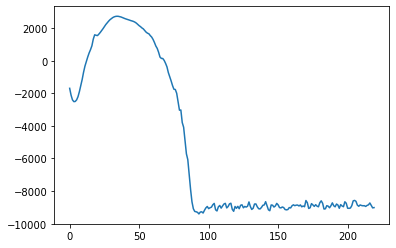

11
Epoch 0/20
99/99 [==============================] - trainLoss: 16.1065  Val_loss: -1171.5031 
Epoch 1/20
99/99 [==============================] - trainLoss: 8.2904  Val_loss: -1686.1376 
Epoch 2/20
99/99 [==============================] - trainLoss: -1.9693  Val_loss: -2156.7305 
Epoch 3/20
99/99 [==============================] - trainLoss: -11.6347  Val_loss: -2578.4856 
Epoch 4/20
99/99 [==============================] - trainLoss: -18.9932  Val_loss: -2948.8613 
Epoch 5/20
99/99 [==============================] - trainLoss: -27.3863  Val_loss: -3285.1489 
Epoch 6/20
99/99 [==============================] - trainLoss: -30.7128  Val_loss: -3576.0244 
Epoch 7/20
99/99 [==============================] - trainLoss: -39.2287  Val_loss: -3817.5872 
Epoch 8/20
99/99 [==============================] - trainLoss: -44.3776  Val_loss: -3942.7461 
Epoch 9/20
99/99 [==============================] - trainLoss: -53.7308  Val_loss: -3977.3845 
Epoch 10/20
99/99 [==============================] 

99/99 [==============================] - trainLoss: -96.8754  Val_loss: -9234.7139 
Epoch 87/200
99/99 [==============================] - trainLoss: -96.2808  Val_loss: -9349.0850 
Epoch 88/200
99/99 [==============================] - trainLoss: -95.6571  Val_loss: -9105.7627 
Epoch 89/200
99/99 [==============================] - trainLoss: -98.9169  Val_loss: -9176.1064 
Epoch 90/200
99/99 [==============================] - trainLoss: -96.1409  Val_loss: -9223.9238 
Epoch 91/200
99/99 [==============================] - trainLoss: -97.4519  Val_loss: -9156.4092 
Epoch 92/200
99/99 [==============================] - trainLoss: -97.0719  Val_loss: -9256.2500 
Epoch 93/200
99/99 [==============================] - trainLoss: -98.1543  Val_loss: -9201.5244 
Epoch 94/200
99/99 [==============================] - trainLoss: -98.6903  Val_loss: -9267.6826 
Epoch 95/200
99/99 [==============================] - trainLoss: -96.6113  Val_loss: -9230.6572 
Epoch 96/200
99/99 [=======================

99/99 [==============================] - trainLoss: -99.8602  Val_loss: -9005.4795 
Epoch 171/200
99/99 [==============================] - trainLoss: -98.5996  Val_loss: -8920.5400 
Epoch 172/200
99/99 [==============================] - trainLoss: -97.1192  Val_loss: -8854.6631 
Epoch 173/200
99/99 [==============================] - trainLoss: -98.3002  Val_loss: -9003.1279 
Epoch 174/200
99/99 [==============================] - trainLoss: -99.1370  Val_loss: -9227.1299 
Epoch 175/200
99/99 [==============================] - trainLoss: -99.1713  Val_loss: -9050.3789 
Epoch 176/200
99/99 [==============================] - trainLoss: -98.0779  Val_loss: -8854.7139 
Epoch 177/200
99/99 [==============================] - trainLoss: -98.1866  Val_loss: -8699.3203 
Epoch 178/200
99/99 [==============================] - trainLoss: -98.5478  Val_loss: -8721.1006 
Epoch 179/200
99/99 [==============================] - trainLoss: -98.0942  Val_loss: -9162.3447 
Epoch 180/200
99/99 [=============

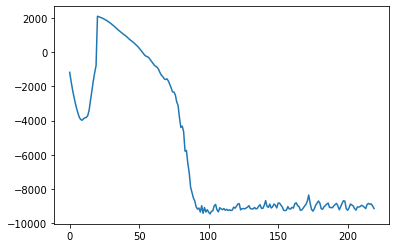

12
Epoch 0/20
99/99 [==============================] - trainLoss: 48.4592  Val_loss: 301.0231 
Epoch 1/20
99/99 [==============================] - trainLoss: 39.2449  Val_loss: -370.0229 
Epoch 2/20
99/99 [==============================] - trainLoss: 29.9280  Val_loss: -983.3481 
Epoch 3/20
99/99 [==============================] - trainLoss: 21.2447  Val_loss: -1561.9536 
Epoch 4/20
99/99 [==============================] - trainLoss: 14.4643  Val_loss: -2085.0320 
Epoch 5/20
99/99 [==============================] - trainLoss: 5.2892  Val_loss: -2537.7886 
Epoch 6/20
99/99 [==============================] - trainLoss: -4.1125  Val_loss: -2895.0474 
Epoch 7/20
99/99 [==============================] - trainLoss: -12.8247  Val_loss: -3118.5510 
Epoch 8/20
99/99 [==============================] - trainLoss: -22.9884  Val_loss: -3191.2546 
Epoch 9/20
99/99 [==============================] - trainLoss: -29.7680  Val_loss: -3119.6592 
Epoch 10/20
99/99 [==============================] - trainL

99/99 [==============================] - trainLoss: -19.3694  Val_loss: -577.9427 
Epoch 44/200
99/99 [==============================] - trainLoss: -20.5786  Val_loss: -719.1942 
Epoch 45/200
99/99 [==============================] - trainLoss: -20.2221  Val_loss: -867.1260 
Epoch 46/200
99/99 [==============================] - trainLoss: -21.8972  Val_loss: -1019.7310 
Epoch 47/200
99/99 [==============================] - trainLoss: -23.5433  Val_loss: -1176.2190 
Epoch 48/200
99/99 [==============================] - trainLoss: -24.0261  Val_loss: -1329.8110 
Epoch 49/200
99/99 [==============================] - trainLoss: -25.1204  Val_loss: -1498.3545 
Epoch 50/200
99/99 [==============================] - trainLoss: -26.3571  Val_loss: -1676.8627 
Epoch 51/200
99/99 [==============================] - trainLoss: -27.7722  Val_loss: -1860.7834 
Epoch 52/200
99/99 [==============================] - trainLoss: -29.6119  Val_loss: -2016.5211 
Epoch 53/200
99/99 [==========================

99/99 [==============================] - trainLoss: -95.6927  Val_loss: -9366.2031 
Epoch 85/200
99/99 [==============================] - trainLoss: -96.1080  Val_loss: -9328.2012 
Epoch 86/200
99/99 [==============================] - trainLoss: -96.1836  Val_loss: -9306.5889 
Epoch 87/200
99/99 [==============================] - trainLoss: -96.9257  Val_loss: -9322.8896 
Epoch 88/200
99/99 [==============================] - trainLoss: -96.1411  Val_loss: -9300.3545 
Epoch 89/200
99/99 [==============================] - trainLoss: -96.9970  Val_loss: -9151.9277 
Epoch 90/200
99/99 [==============================] - trainLoss: -95.5272  Val_loss: -8935.0215 
Epoch 91/200
99/99 [==============================] - trainLoss: -97.1833  Val_loss: -9251.9258 
Epoch 92/200
99/99 [==============================] - trainLoss: -96.2981  Val_loss: -9126.5400 
Epoch 93/200
99/99 [==============================] - trainLoss: -96.6655  Val_loss: -9146.5850 
Epoch 94/200
99/99 [=======================

99/99 [==============================] - trainLoss: -97.6870  Val_loss: -9297.5508 
Epoch 169/200
99/99 [==============================] - trainLoss: -99.6128  Val_loss: -9082.8037 
Epoch 170/200
99/99 [==============================] - trainLoss: -99.1234  Val_loss: -9343.2031 
Epoch 171/200
99/99 [==============================] - trainLoss: -97.5999  Val_loss: -9334.4736 
Epoch 172/200
99/99 [==============================] - trainLoss: -97.6159  Val_loss: -9171.5977 
Epoch 173/200
99/99 [==============================] - trainLoss: -97.2614  Val_loss: -9065.7578 
Epoch 174/200
99/99 [==============================] - trainLoss: -98.4187  Val_loss: -9015.7578 
Epoch 175/200
99/99 [==============================] - trainLoss: -98.9469  Val_loss: -9166.4834 
Epoch 176/200
99/99 [==============================] - trainLoss: -97.8372  Val_loss: -9072.3809 
Epoch 177/200
99/99 [==============================] - trainLoss: -97.9468  Val_loss: -9092.9629 
Epoch 178/200
99/99 [=============

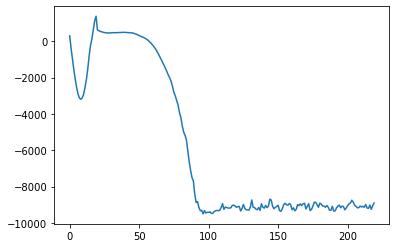

13
Epoch 0/20
99/99 [==============================] - trainLoss: 8.3671  Val_loss: -1397.3223 
Epoch 1/20
99/99 [==============================] - trainLoss: -3.2939  Val_loss: -1843.7908 
Epoch 2/20
99/99 [==============================] - trainLoss: -10.0439  Val_loss: -2200.1301 
Epoch 3/20
99/99 [==============================] - trainLoss: -21.3691  Val_loss: -2446.2390 
Epoch 4/20
99/99 [==============================] - trainLoss: -29.0830  Val_loss: -2594.2983 
Epoch 5/20
99/99 [==============================] - trainLoss: -41.6375  Val_loss: -2684.3369 
Epoch 6/20
99/99 [==============================] - trainLoss: -45.7096  Val_loss: -2729.6089 
Epoch 7/20
99/99 [==============================] - trainLoss: -55.6587  Val_loss: -2698.7622 
Epoch 8/20
99/99 [==============================] - trainLoss: -66.9656  Val_loss: -2650.2134 
Epoch 9/20
99/99 [==============================] - trainLoss: -72.7078  Val_loss: -2590.0583 
Epoch 10/20
99/99 [==============================]

99/99 [==============================] - trainLoss: -34.9217  Val_loss: -1059.1434 
Epoch 46/200
99/99 [==============================] - trainLoss: -36.8968  Val_loss: -1231.6506 
Epoch 47/200
99/99 [==============================] - trainLoss: -37.0680  Val_loss: -1343.4020 
Epoch 48/200
99/99 [==============================] - trainLoss: -39.0087  Val_loss: -1352.8105 
Epoch 49/200
99/99 [==============================] - trainLoss: -39.7759  Val_loss: -1480.4684 
Epoch 50/200
99/99 [==============================] - trainLoss: -42.0276  Val_loss: -1664.1604 
Epoch 51/200
99/99 [==============================] - trainLoss: -42.5406  Val_loss: -1982.9928 
Epoch 52/200
99/99 [==============================] - trainLoss: -43.8252  Val_loss: -2099.2512 
Epoch 53/200
99/99 [==============================] - trainLoss: -45.0073  Val_loss: -2270.8191 
Epoch 54/200
99/99 [==============================] - trainLoss: -46.1523  Val_loss: -2400.3118 
Epoch 55/200
99/99 [=======================

99/99 [==============================] - trainLoss: -99.2184  Val_loss: -7984.9863 
Epoch 179/200
99/99 [==============================] - trainLoss: -99.8478  Val_loss: -8033.6875 
Epoch 180/200
99/99 [==============================] - trainLoss: -99.8540  Val_loss: -8008.9238 
Epoch 181/200
99/99 [==============================] - trainLoss: -99.7212  Val_loss: -8284.9277 
Epoch 182/200
99/99 [==============================] - trainLoss: -99.3377  Val_loss: -8244.6514 
Epoch 183/200
99/99 [==============================] - trainLoss: -99.3092  Val_loss: -8348.8613 
Epoch 184/200
99/99 [==============================] - trainLoss: -101.1791  Val_loss: -8662.6748 
Epoch 185/200
99/99 [==============================] - trainLoss: -99.9446  Val_loss: -8480.8242 
Epoch 186/200
99/99 [==============================] - trainLoss: -98.4458  Val_loss: -8166.5991 
Epoch 187/200
99/99 [==============================] - trainLoss: -97.9299  Val_loss: -7708.5952 
Epoch 188/200
99/99 [============

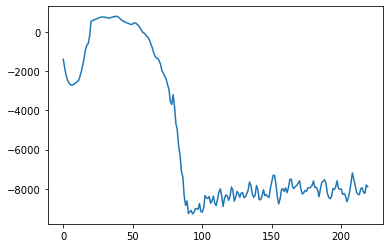

14
Epoch 0/20
99/99 [==============================] - trainLoss: 10.8337  Val_loss: -1545.1060 
Epoch 1/20
99/99 [==============================] - trainLoss: 0.0900  Val_loss: -1720.1171 
Epoch 2/20
99/99 [==============================] - trainLoss: -9.9057  Val_loss: -1791.1509 
Epoch 3/20
99/99 [==============================] - trainLoss: -16.3307  Val_loss: -1758.3392 
Epoch 4/20
99/99 [==============================] - trainLoss: -22.6697  Val_loss: -1589.4030 
Epoch 5/20
99/99 [==============================] - trainLoss: -32.8741  Val_loss: -1260.9822 
Epoch 6/20
99/99 [==============================] - trainLoss: -40.6555  Val_loss: -767.1212 
Epoch 7/20
99/99 [==============================] - trainLoss: -50.0951  Val_loss: -177.6825 
Epoch 8/20
99/99 [==============================] - trainLoss: -58.5442  Val_loss: 559.0603 
Epoch 9/20
99/99 [==============================] - trainLoss: -66.1394  Val_loss: 1500.7888 
Epoch 10/20
99/99 [==============================] - tra

99/99 [==============================] - trainLoss: -46.4187  Val_loss: -286.4977 
Epoch 56/200
99/99 [==============================] - trainLoss: -48.4318  Val_loss: -89.1070 
Epoch 57/200
99/99 [==============================] - trainLoss: -48.8642  Val_loss: 107.5656 
Epoch 58/200
99/99 [==============================] - trainLoss: -50.6411  Val_loss: -222.5638 
Epoch 59/200
99/99 [==============================] - trainLoss: -52.5758  Val_loss: -751.3058 
Epoch 60/200
99/99 [==============================] - trainLoss: -55.1657  Val_loss: -1197.5654 
Epoch 61/200
99/99 [==============================] - trainLoss: -57.0274  Val_loss: -1865.5005 
Epoch 62/200
99/99 [==============================] - trainLoss: -59.4821  Val_loss: -2443.3650 
Epoch 63/200
99/99 [==============================] - trainLoss: -61.7332  Val_loss: -3789.6003 
Epoch 64/200
99/99 [==============================] - trainLoss: -62.9088  Val_loss: -4326.0688 
Epoch 65/200
99/99 [==============================

99/99 [==============================] - trainLoss: -98.2659  Val_loss: -8178.5547 
Epoch 114/200
99/99 [==============================] - trainLoss: -98.1610  Val_loss: -8232.7900 
Epoch 115/200
99/99 [==============================] - trainLoss: -100.2947  Val_loss: -8620.7393 
Epoch 116/200
99/99 [==============================] - trainLoss: -98.0344  Val_loss: -8424.6045 
Epoch 117/200
99/99 [==============================] - trainLoss: -98.3757  Val_loss: -8126.1826 
Epoch 118/200
99/99 [==============================] - trainLoss: -97.1004  Val_loss: -7393.0669 
Epoch 119/200
99/99 [==============================] - trainLoss: -98.3212  Val_loss: -7359.8345 
Epoch 120/200
99/99 [==============================] - trainLoss: -97.8576  Val_loss: -7695.1396 
Epoch 121/200
99/99 [==============================] - trainLoss: -98.2901  Val_loss: -7905.9565 
Epoch 122/200
99/99 [==============================] - trainLoss: -98.9703  Val_loss: -8185.7192 
Epoch 123/200
99/99 [============

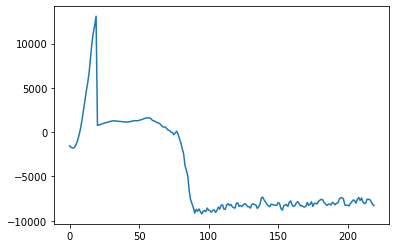

In [6]:
test_loglik_list = []
val_loglik_list = []

for i in range(15):
    
    print(i)

    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state = keras.layers.GRU(hidden_state_size,return_sequences=True,return_state=True)(inputs=x_in,initial_state=hidden_state_in)

    hidden_model = keras.models.Model(inputs=[x_in,x_out,hidden_state_in],outputs=[output2,state])


    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])
    hr_out = keras.layers.Input(shape=[None,num_dims_hr])
    hr_in = keras.layers.Input(shape=[None,num_dims_hr])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state= hidden_model([x_in,x_out,hidden_state_in])

    layer_hr = keras.layers.Dropout(0.3)(output2)
    layer_hr = keras.layers.Dense(16,activation="elu")(layer_hr)
    layer_hr = keras.layers.Dropout(0.3)(layer_hr)
    final_hr_mean = keras.layers.TimeDistributed(keras.layers.Dense(num_dims_hr,bias_initializer='zeros'))(layer_hr) + hr_in
    sigma_mle_hr = (K.mean((final_hr_mean- hr_out)**2))**0.5

    loglik_hr = loglik_gaussian_hr(hr_out,final_hr_mean,sigma_mle_hr)

    nloglik_hr = loss(loglik_hr)

    rnn_training_hr = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[nloglik_hr])
    rnn_generate_hr = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[final_hr_mean,sigma_mle_hr,state])


    x_in = keras.layers.Input(shape=[None,num_dims])
    x_out = keras.layers.Input(shape=[None,num_dims])
    hr_out = keras.layers.Input(shape=[None,num_dims_hr])
    hr_in = keras.layers.Input(shape=[None,num_dims_hr])

    hidden_state_in = keras.layers.Input(shape=[hidden_state_size])

    output2,state = hidden_model([x_in,x_out,hidden_state_in],training=False)

    layer = keras.layers.Dropout(0.3)(output2)
    layer = keras.layers.Dense(8,activation="elu")(layer)
    layer = keras.layers.Dropout(0.3)(layer)
    final_x_mean = keras.layers.TimeDistributed(keras.layers.Dense(num_dims,bias_initializer='zeros'))(layer) + x_in #this means we predict the residuals (better for learning)
    sigma_mle_x = (K.mean((final_x_mean- x_out)**2))**0.5


    loglik_x = loglik_gaussian_x(x_out,final_x_mean,sigma_mle_x)

    nloglikx = loss(loglik_x)

    rnn_training_x = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[nloglikx])
    rnn_generate_x = keras.models.Model(inputs=[x_in,x_out,hr_in,hr_out,hidden_state_in],outputs=[final_x_mean,sigma_mle_x,state])

    @tf.function
    def train_step(inputs,model):
        """Decorated train_step function which applies a gradient update to the parameters"""
        with tf.GradientTape() as tape:
            loss = model(inputs,training=True)
            loss = tf.add_n([loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    optimizer=keras.optimizers.Adam(learning_rate=0.001)

    def fit_model(input_list,epochs,model,simulator,history,validation_loss
                  ,valid_list,hr_toggle,index,batch_size=32):

        start = time.time()
        K.clear_session()

        batch_loss = []
        batches_per_epoch = int(np.ceil(input_list[0].shape[0]/batch_size))
        
        rnn_generate_x.save("tl_models/{}.h5".format(index))
        
        for epoch in range(epochs):
                print("Epoch {}/{}".format(epoch,epochs))
                for i in range(batches_per_epoch):
                    batch_list= create_batch(
                        input_list,batch_size)
                    loss = train_step(batch_list,model)
                    batch_loss.append(loss)
                    average_batch_loss = list_average(batch_loss)
                    print_status_bar(i*batch_size,input_list[0].shape[0],average_batch_loss)

                training_loss_for_epoch = list_average(batch_loss)
                batch_loss = []
                history.append(training_loss_for_epoch)

                sigma_mle = simulator(input_list)[1]

                val_loss = valid_loss(valid_list,simulator=simulator,sigma_x = sigma_mle,hr=hr_toggle)

                validation_loss.append(val_loss)
                if val_loss == min(validation_loss):
                    rnn_generate_x.save("tl_models/{}.h5".format(index))

                print_status_bar_epoch(input_list[0].shape[0]
                                 ,input_list[0].shape[0],training_loss_for_epoch,val_loss )

        done = time.time()
        elapsed = done-start

        
    training_losses = []
    validation_losses = []
    
    
    fit_model(input_list,20,rnn_training_hr,rnn_generate_hr,training_losses,validation_losses
              ,valid_list,hr_toggle=True,index=i,batch_size=32)
    
    
    hidden_model.trainable=False
    
    training_losses = []
    validation_losses = []
    
    @tf.function
    def train_step(inputs,model):
        """Decorated train_step function which applies a gradient update to the parameters"""
        with tf.GradientTape() as tape:
            loss = model(inputs,training=True)
            loss = tf.add_n([loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    optimizer=keras.optimizers.Adam(learning_rate=0.001)

    def fit_model(input_list,epochs,model,simulator,history,validation_loss
                  ,valid_list,hr_toggle,index,batch_size=32):

        start = time.time()
        K.clear_session()

        batch_loss = []
        batches_per_epoch = int(np.ceil(input_list[0].shape[0]/batch_size))
        
        rnn_generate_x.save("tl_models/{}.h5".format(index))
        
        for epoch in range(epochs):
                print("Epoch {}/{}".format(epoch,epochs))
                for i in range(batches_per_epoch):
                    batch_list= create_batch(
                        input_list,batch_size)
                    loss = train_step(batch_list,model)
                    batch_loss.append(loss)
                    average_batch_loss = list_average(batch_loss)
                    print_status_bar(i*batch_size,input_list[0].shape[0],average_batch_loss)

                training_loss_for_epoch = list_average(batch_loss)
                batch_loss = []
                history.append(training_loss_for_epoch)

                sigma_mle = simulator(input_list)[1]

                val_loss = valid_loss(valid_list,simulator=simulator,sigma_x = sigma_mle,hr=hr_toggle)

                validation_loss.append(val_loss)
                if val_loss == min(validation_loss):
                    rnn_generate_x.save("tl_models/{}.h5".format(index))

                print_status_bar_epoch(input_list[0].shape[0]
                                 ,input_list[0].shape[0],training_loss_for_epoch,val_loss )

        done = time.time()
        elapsed = done-start

        plt.plot(validation_loss,label="validation")
        plt.show()

    fit_model(input_list,200,rnn_training_x,rnn_generate_x,training_losses,validation_losses
              ,valid_list,hr_toggle=False,index=i,batch_size=32)
    
    


    rnn_generate_x = keras.models.load_model("tl_models/{}.h5".format(i))
    
    sigma_x = rnn_generate_x(input_list)[1]
    mean = rnn_generate_x(test_list)[0]
    loglik = np.mean(loglik_gaussian_x(test_nn_output,mean,sigma_x))

    test_loglik_list.append(loglik)
    
    mean = rnn_generate_x(valid_list)[0]
    loglik = np.mean(loglik_gaussian_x(valid_nn_output,mean,sigma_x))

    val_loglik_list.append(loglik)
    
a = np.array(test_loglik_list)
b = np.array(val_loglik_list)
array_loglik = np.stack([b,a],axis=1)
np.save("tl_models/loglik_array.npy",array_loglik)


In [7]:
array_loglik

array([[   9447.353, 2779064.2  ],
       [   9129.026, 2678161.5  ],
       [   9420.567, 2713152.   ],
       [   9119.233, 2703558.   ],
       [   9398.688, 2734757.8  ],
       [   9459.448, 2763107.2  ],
       [   9522.136, 2778008.2  ],
       [   9453.144, 2765898.5  ],
       [   9365.953, 2756722.   ],
       [   9540.198, 2792608.2  ],
       [   9400.421, 2744609.5  ],
       [   9470.63 , 2775609.5  ],
       [   9500.283, 2794984.   ],
       [   9282.673, 2760949.5  ],
       [   9234.495, 2736996.   ]], dtype=float32)

# Best models

In [2]:
from sklearn.metrics import r2_score

## No TL

In [3]:
loglik_array = np.load("no_tl_models/loglik_array.npy")
loglik_array

array([[ 1.6753729e+03,  1.3989975e+06],
       [ 2.2109958e+03,  1.9560465e+06],
       [ 1.7163282e+03,  1.6983150e+06],
       [ 2.7829414e+03,  1.4063108e+06],
       [ 4.2518799e+03,  1.4718738e+06],
       [-1.1344034e+03, -9.0117445e+04],
       [ 5.3731134e+02, -2.9211159e+05],
       [ 5.8165449e+03,  2.1455115e+06],
       [-7.6814703e+02, -2.1399133e+05],
       [ 1.4390370e+03,  7.1822850e+05],
       [ 4.1379209e+03,  1.4822712e+06],
       [ 2.5738913e+02,  1.8782148e+06],
       [ 4.0522866e+03,  1.9413259e+06],
       [-1.2877104e+03, -1.9659972e+05],
       [ 4.4812061e+03,  1.6783796e+06]], dtype=float32)

In [4]:
index = np.argmax(loglik_array[:,0])
index

7

In [5]:
loglik_array[index,1]

2145511.5

In [7]:
rnn_no_tl = keras.models.load_model("no_tl_models/{}.h5".format(index))

2022-09-11 16:27:23.553984: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-11 16:27:24.254611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5208 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:3b:00.0, compute capability: 6.1


In [8]:
sigma = rnn_no_tl(input_list)[1]
sigma

2022-09-11 16:27:29.226607: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


<tf.Tensor: shape=(), dtype=float32, numpy=0.0019546913>

In [9]:
mean = rnn_no_tl(test_list)[0]

r2_score(np.ravel(test_list[1]),np.ravel(mean))

0.9999871771163216

In [10]:
np.mean((test_list[1] - mean)**2)

1.3316415e-05

## TL

In [5]:
loglik_array = np.load("tl_models/loglik_array.npy")
loglik_array

array([[   9447.353, 2779064.2  ],
       [   9129.026, 2678161.5  ],
       [   9420.567, 2713152.   ],
       [   9119.233, 2703558.   ],
       [   9398.688, 2734757.8  ],
       [   9459.448, 2763107.2  ],
       [   9522.136, 2778008.2  ],
       [   9453.144, 2765898.5  ],
       [   9365.953, 2756722.   ],
       [   9540.198, 2792608.2  ],
       [   9400.421, 2744609.5  ],
       [   9470.63 , 2775609.5  ],
       [   9500.283, 2794984.   ],
       [   9282.673, 2760949.5  ],
       [   9234.495, 2736996.   ]], dtype=float32)

In [6]:
index = np.argmax(loglik_array[:,0])
index

9

In [7]:
loglik_array[index,1]

2792608.2

In [8]:
loglik_array[index,1] / 30000

93.08694166666666

In [9]:
rnn_tl = keras.models.load_model("tl_models/{}.h5".format(index))

2022-09-11 17:04:44.785406: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-11 17:04:45.463504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5699 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:3b:00.0, compute capability: 6.1


In [12]:
sigma = rnn_tl(input_list)[1]
sigma

2022-09-11 17:04:53.170404: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


<tf.Tensor: shape=(), dtype=float32, numpy=0.001787844>

In [13]:
mean = rnn_tl(test_list)[0]

r2_score(np.ravel(test_list[1]),np.ravel(mean))

0.999995362777461

In [14]:
np.mean((test_list[1] - mean)**2)

4.815701e-06